## Modelling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The goal of the section is to develop a model with best model evaluation parameters. Numerous algorithms will be tested followed by hyperparameter tuning to obtain a best performing model.  

## Importing basic libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy

import warnings
warnings.filterwarnings(action='ignore')


# Train-Test Splitting
from sklearn.model_selection import train_test_split

# Data Scaling using MinMax Scalar
from sklearn.preprocessing import MinMaxScaler

#Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
import lightgbm as lgb


# Model evaluation matrices
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score

#Class balance
from imblearn.over_sampling import SMOTE

#PCA
from sklearn.decomposition import PCA

#Gridsearch/Randomizedsearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV






## 1) Baseline Model 

For the classification problem, baseline model can be considered as a model with area under ROC curve equal to 0.5. Here we consider a slightly higher predictive model, Logistic regression model as a baseline model considering the data from the main dataset: Application Train.


In [ ]:
# Load datasets: df contains data from Application_train dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone_two_final/Final_data/final_application_train_corr_0.98.csv')
df.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,FLAG_DOCUMENT_2_1,FLAG_DOCUMENT_3_1,FLAG_DOCUMENT_4_1,FLAG_DOCUMENT_5_1,FLAG_DOCUMENT_6_1,FLAG_DOCUMENT_7_1,FLAG_DOCUMENT_8_1,FLAG_DOCUMENT_9_1,FLAG_DOCUMENT_10_1,FLAG_DOCUMENT_11_1,FLAG_DOCUMENT_12_1,FLAG_DOCUMENT_13_1,FLAG_DOCUMENT_14_1,FLAG_DOCUMENT_15_1,FLAG_DOCUMENT_16_1,FLAG_DOCUMENT_17_1,FLAG_DOCUMENT_18_1,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_1
0,100002,1,202500.0,406597.5,24700.5,0.018801,9461,637,3648.0,2120,0.0,10,0.083037,0.262949,0.139376,0.02470,0.036900,0.972200,0.619200,0.014300,0.000000,0.069000,0.083300,0.125000,0.036900,0.020200,0.019000,0.000000,0.00000,0.025200,0.038300,0.972200,0.014400,0.000000,0.069000,0.037700,0.022000,0.019800,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,270000.0,1293502.5,35698.5,0.003541,16765,1188,1186.0,291,0.0,11,0.311267,0.622246,0.521008,0.09590,0.052900,0.985100,0.796000,0.060500,0.080000,0.034500,0.291700,0.333300,0.013000,0.077300,0.054900,0.003900,0.00980,0.092400,0.053800,0.985100,0.049700,0.080600,0.034500,0.012800,0.079000,0.055400,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100004,0,67500.0,135000.0,6750.0,0.010032,19046,225,4260.0,2531,26.0,9,0.511522,0.555912,0.729567,0.11746,0.088453,0.977731,0.752471,0.044619,0.078962,0.149741,0.226312,0.231916,0.066338,0.100787,0.107424,0.008811,0.02836,0.114249,0.087553,0.977061,0.042551,0.074508,0.145208,0.064962,0.105657,0.105999,0.008078,0.027024,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,0.008019,19005,3039,9833.0,2437,0.0,17,0.511522,0.650442,0.521008,0.11746,0.088453,0.977731,0.752471,0.044619,0.078962,0.149741,0.226312,0.231916,0.066338,0.100787,0.107424,0.008811,0.02836,0.114249,0.087553,0.977061,0.042551,0.074508,0.145208,0.064962,0.105657,0.105999,0.008078,0.027024,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,21865.5,0.028663,19932,3038,4311.0,3458,0.0,11,0.511522,0.322738,0.521008,0.11746,0.088453,0.977731,0.752471,0.044619,0.078962,0.149741,0.226312,0.231916,0.066338,0.100787,0.107424,0.008811,0.02836,0.114249,0.087553,0.977061,0.042551,0.074508,0.145208,0.064962,0.105657,0.105999,0.008078,0.027024,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### Test train split and scaling

In [ ]:
# Variable separation: Features and Target
X=df.drop(['TARGET','SK_ID_CURR'], axis=1).values
y=df['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

### Baseline Model: Logistic Regression

Test Data Metrics:
[[56038   463]
 [ 4603   340]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56501
           1       0.42      0.07      0.12      4943

    accuracy                           0.92     61444
   macro avg       0.67      0.53      0.54     61444
weighted avg       0.88      0.92      0.89     61444



Train Data Metrics:
[[224154   1758]
 [ 18411   1449]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96    225912
           1       0.45      0.07      0.13     19860

    accuracy                           0.92    245772
   macro avg       0.69      0.53      0.54    245772
weighted avg       0.89      0.92      0.89    245772



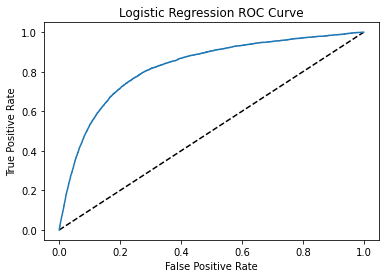



ROC_AUC Score:
roc_auc (test): 0.825
roc_auc (training): 0.823


In [ ]:
# Train the Logistic Regression model on the Training set
classifier_LR = LogisticRegression(random_state = 0)
classifier_LR.fit(X_train, y_train)

# Predic the Test set results
y_pred = classifier_LR.predict(X_test)

# Model evaluation matrices
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

#ROC_AUC Curve/Score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print('\n')
print('ROC_AUC Score:')
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))

**Baseline Model:** Roc_AUC(TEST)=0.825, the recall for 0 is exceptionally high and that for 1 is extremely low.

# 2) Search for Best Model

### Data Overview



In [ ]:
#Load dataset: df contains application_train and features extracted from additional datasets 
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone_two_final/Final_data/final_df_corr_0.98.csv')
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307216 entries, 0 to 307215
Data columns (total 528 columns):
 #   Column                                                          Non-Null Count   Dtype  
---  ------                                                          --------------   -----  
 0   SK_ID_CURR                                                      307216 non-null  int64  
 1   TARGET                                                          307216 non-null  int64  
 2   AMT_INCOME_TOTAL                                                307216 non-null  float64
 3   AMT_CREDIT                                                      307216 non-null  float64
 4   AMT_ANNUITY                                                     307216 non-null  float64
 5   REGION_POPULATION_RELATIVE                                      307216 non-null  float64
 6   DAYS_BIRTH                                                      307216 non-null  int64  
 7   DAYS_EMPLOYED                        

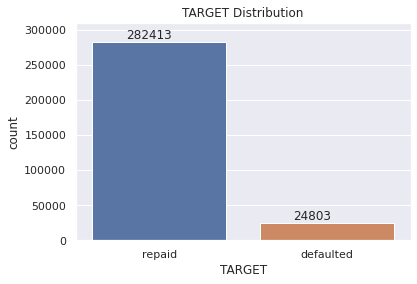

In [ ]:
#Targets
sns.set()
ax=sns.countplot(df['TARGET'])
plt.xticks([1,0],['defaulted', 'repaid'])
plt.ylim([0,310000])
plt.title('TARGET Distribution')

for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+5000))

In [ ]:
#check for null values
df.isnull().values.any()

False

### Test train split and scaling

In [ ]:
# Variable separation: Features and Target
X=df.drop(['TARGET','SK_ID_CURR'], axis=1).values
y=df['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

### 2.1) Logistic Regression

In [ ]:
# Train the Logistic Regression model on the Training set
classifier_LR = LogisticRegression(random_state = 0)
classifier_LR.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_LR.predict(X_test)

# Model evaluation matrices
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print('\n')
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))

Test Data Metrics:
[[55992   509]
 [ 4460   483]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     56501
           1       0.49      0.10      0.16      4943

    accuracy                           0.92     61444
   macro avg       0.71      0.54      0.56     61444
weighted avg       0.89      0.92      0.89     61444



Train Data Metrics:
[[223966   1946]
 [ 17959   1901]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96    225912
           1       0.49      0.10      0.16     19860

    accuracy                           0.92    245772
   macro avg       0.71      0.54      0.56    245772
weighted avg       0.89      0.92      0.89    245772



roc_auc (test): 0.833
roc_auc (training): 0.831


In [ ]:
#Feature importance LR
feature_importances_LR=abs(classifier_LR.coef_)[0]
features= df.drop(['TARGET','SK_ID_CURR'], axis=1).columns
feature_importances_LR=pd.DataFrame(list(zip(features,feature_importances_LR/max(feature_importances_LR)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LR.head(10)

,features,importance
10,EXT_SOURCE_1,100.000000
12,EXT_SOURCE_3,54.846682
2,AMT_ANNUITY,40.296213
50,count_bureau_CREDIT_ACTIVE_type_Active,33.113041
40,DEF_30_CNT_SOCIAL_CIRCLE,32.534640
41,DEF_60_CNT_SOCIAL_CIRCLE,30.932824
313,POS_CASH_CNT_INSTALMENT_FUTURE_sum,30.130981
269,installments_payments_NUM_INSTALMENT_VERSION_std,30.059033
11,EXT_SOURCE_2,28.707827
59,count_bureau_CREDIT_TYPE_type_Mortgage,26.620110


#### 2.1.1) Weighted LR

In [ ]:
classifier_LR = LogisticRegression(random_state = 0, class_weight={0:1,1:10})
classifier_LR.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_LR.predict(X_test)

#Confusion Matrix/Classification Report
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
y_pred_train=classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

#ROC_AUC Score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[45277 11224]
 [ 1265  3678]]
              precision    recall  f1-score   support

           0       0.97      0.80      0.88     56501
           1       0.25      0.74      0.37      4943

    accuracy                           0.80     61444
   macro avg       0.61      0.77      0.62     61444
weighted avg       0.91      0.80      0.84     61444



Train Data Metrics:
[[180765  45147]
 [  5100  14760]]
              precision    recall  f1-score   support

           0       0.97      0.80      0.88    225912
           1       0.25      0.74      0.37     19860

    accuracy                           0.80    245772
   macro avg       0.61      0.77      0.62    245772
weighted avg       0.91      0.80      0.84    245772

roc_auc (training): 0.835
roc_auc (test): 0.836


##### 2.1.2) L1/L2 regularized LR

In [ ]:
classifier_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')
classifier_LR.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_LR.predict(X_test)
y_pred_train=classifier_LR.predict(X_train)

# Confusion Matrix/Classification Report
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


#ROC_AUC Score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[45308 11193]
 [ 1266  3677]]
              precision    recall  f1-score   support

           0       0.97      0.80      0.88     56501
           1       0.25      0.74      0.37      4943

    accuracy                           0.80     61444
   macro avg       0.61      0.77      0.63     61444
weighted avg       0.91      0.80      0.84     61444



Train Data Metrics:
[[180873  45039]
 [  5001  14859]]
              precision    recall  f1-score   support

           0       0.97      0.80      0.88    225912
           1       0.25      0.75      0.37     19860

    accuracy                           0.80    245772
   macro avg       0.61      0.77      0.63    245772
weighted avg       0.91      0.80      0.84    245772

roc_auc (training): 0.838
roc_auc (test): 0.837


In [ ]:
feature_importances_LR=abs(classifier_LR.coef_)[0]
features= df.drop(['TARGET','SK_ID_CURR'], axis=1).columns
feature_importances_LR=pd.DataFrame(list(zip(features,feature_importances_LR/max(feature_importances_LR)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LR.head(10)

,features,importance
294,installments_payments_AMT_PAYMENT_min,100.000000
115,bureau_AMT_CREDIT_SUM_DEBT_var,54.985041
285,installments_payments_AMT_INSTALMENT_mean,51.407411
292,installments_payments_AMT_PAYMENT_mean,43.676959
275,installments_payments_NUM_INSTALMENT_NUMBER_sum,41.059116
277,installments_payments_NUM_INSTALMENT_NUMBER_var,37.050260
212,credit_card_balance_AMT_PAYMENT_CURRENT_sum,33.538382
113,bureau_AMT_CREDIT_SUM_DEBT_sum,27.575513
95,bureau_AMT_CREDIT_MAX_OVERDUE_var,27.215182
288,installments_payments_AMT_INSTALMENT_min,27.117947


##### 2.1.2) LR with elsticnet regularization

In [ ]:
classifier_LR = LogisticRegression(solver='saga', random_state = 0, class_weight={0:1,1:10}, penalty='elasticnet', l1_ratio=0.5)
classifier_LR.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_LR.predict(X_test)
y_pred_train=classifier_LR.predict(X_train)

# Confusion Matrix/Classification Report
from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


#ROC_AUC Score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[42022 14479]
 [ 1104  3839]]
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     56501
           1       0.21      0.78      0.33      4943

    accuracy                           0.75     61444
   macro avg       0.59      0.76      0.59     61444
weighted avg       0.91      0.75      0.80     61444



Train Data Metrics:
[[167586  58326]
 [  4425  15435]]
              precision    recall  f1-score   support

           0       0.97      0.74      0.84    225912
           1       0.21      0.78      0.33     19860

    accuracy                           0.74    245772
   macro avg       0.59      0.76      0.59    245772
weighted avg       0.91      0.74      0.80    245772

roc_auc (training): 0.826
roc_auc (test): 0.825


### 2.2) Decision Tree

In [ ]:
classifier_DT = DecisionTreeClassifier(random_state = 0)
classifier_DT.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_DT.predict(X_test)
y_pred_train=classifier_DT.predict(X_train)

# Confusion Matrix/classification Report
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

#ROC_AUC Score
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_DT.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[54932  1569]
 [ 1344  3599]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     56501
           1       0.70      0.73      0.71      4943

    accuracy                           0.95     61444
   macro avg       0.84      0.85      0.84     61444
weighted avg       0.95      0.95      0.95     61444



Train Data Metrics:
[[225912      0]
 [     0  19860]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    225912
           1       1.00      1.00      1.00     19860

    accuracy                           1.00    245772
   macro avg       1.00      1.00      1.00    245772
weighted avg       1.00      1.00      1.00    245772

roc_auc (training): 1.000
roc_auc (test): 0.850


#### 2.2.1) Weighted Decision Tree

In [ ]:
classifier_DT = DecisionTreeClassifier(class_weight={0:1,1:10},random_state = 0)
classifier_DT.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_DT.predict(X_test)
y_pred_train=classifier_DT.predict(X_train)

# Confusion Matrix/classification Report
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

#ROC_AUC Score
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_DT.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

### 2.3) Random Forest classifier

In [ ]:
classifier_RF=RandomForestClassifier(random_state=0)

classifier_RF.fit(X_train,y_train)

# Predict the Test set results
y_pred = classifier_RF.predict(X_test)
y_pred_train=classifier_RF.predict(X_train)

# Confusion Matrix/classification Report
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


#ROC_AUC Score
y_pred_prob = classifier_RF.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_RF.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[56489    12]
 [ 3403  1540]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     56501
           1       0.99      0.31      0.47      4943

    accuracy                           0.94     61444
   macro avg       0.97      0.66      0.72     61444
weighted avg       0.95      0.94      0.93     61444



Train Data Metrics:
[[225912      0]
 [     4  19856]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    225912
           1       1.00      1.00      1.00     19860

    accuracy                           1.00    245772
   macro avg       1.00      1.00      1.00    245772
weighted avg       1.00      1.00      1.00    245772

roc_auc (training): 1.000
roc_auc (test): 0.939


In [ ]:
#Feature importance RF
feature_importance_RF = classifier_RF.feature_importances_
features= df.drop(['TARGET','SK_ID_CURR'], axis=1).columns
feature_importances_RF=pd.DataFrame(list(zip(features,feature_importance_RF/max(feature_importance_RF)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_RF.head(10)


,features,importance
10,EXT_SOURCE_1,100.000000
12,EXT_SOURCE_3,33.644618
11,EXT_SOURCE_2,9.148900
4,DAYS_BIRTH,8.300179
68,bureau_DAYS_CREDIT_min,5.035784
66,bureau_DAYS_CREDIT_median,4.941444
65,bureau_DAYS_CREDIT_mean,4.398765
53,count_bureau_CREDIT_CURRENCY_type_currency 1,4.301951
134,bureau_DAYS_CREDIT_UPDATE_sum,4.002758
133,bureau_DAYS_CREDIT_UPDATE_min,3.879557


#### 2.3.1) Weighted RF

In [ ]:
classifier_RF=RandomForestClassifier(random_state=0, class_weight={0:1,1:10})

classifier_RF.fit(X_train,y_train)

# Predict the Test set results
y_pred = classifier_RF.predict(X_test)
y_pred_train=classifier_RF.predict(X_train)

# Confusion Matrix/classification Report
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


#ROC_AUC Score
y_pred_prob = classifier_RF.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_RF.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[56494     7]
 [ 3752  1191]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     56501
           1       0.99      0.24      0.39      4943

    accuracy                           0.94     61444
   macro avg       0.97      0.62      0.68     61444
weighted avg       0.94      0.94      0.92     61444



Train Data Metrics:
[[225912      0]
 [     6  19854]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    225912
           1       1.00      1.00      1.00     19860

    accuracy                           1.00    245772
   macro avg       1.00      1.00      1.00    245772
weighted avg       1.00      1.00      1.00    245772

roc_auc (training): 1.000
roc_auc (test): 0.944


### 2.4) AdaBoost Classifier

In [ ]:
classifier_AB = AdaBoostClassifier(random_state = 0)
classifier_AB.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_AB.predict(X_test)
y_pred_train=classifier_AB.predict(X_train)

# Confusion Matrix/classification Report
from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

#ROC_AUC Score
y_pred_prob = classifier_AB.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_AB.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[56486    15]
 [ 1711  3232]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     56501
           1       1.00      0.65      0.79      4943

    accuracy                           0.97     61444
   macro avg       0.98      0.83      0.89     61444
weighted avg       0.97      0.97      0.97     61444



Train Data Metrics:
[[225858     54]
 [  6964  12896]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    225912
           1       1.00      0.65      0.79     19860

    accuracy                           0.97    245772
   macro avg       0.98      0.82      0.89    245772
weighted avg       0.97      0.97      0.97    245772

roc_auc (training): 0.969
roc_auc (test): 0.971


### 2.5) Gradient boosting

In [ ]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1,2,5]

for learning_rate in lr_list:
    classifier_gb = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    classifier_gb.fit(X_train, y_train)


    print("Learning rate: ", learning_rate)
    y_pred_prob = classifier_gb.predict_proba(X_test)[:,1]
    y_pred_prob_train = classifier_gb.predict_proba(X_train)[:,1]
    print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
    print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))
    

Learning rate:  0.05
roc_auc (training): 0.667
roc_auc (test): 0.676
Learning rate:  0.075
roc_auc (training): 0.669
roc_auc (test): 0.678
Learning rate:  0.1
roc_auc (training): 0.670
roc_auc (test): 0.678
Learning rate:  0.25
roc_auc (training): 0.675
roc_auc (test): 0.683
Learning rate:  0.5
roc_auc (training): 0.680
roc_auc (test): 0.687
Learning rate:  0.75
roc_auc (training): 0.684
roc_auc (test): 0.690
Learning rate:  1
roc_auc (training): 0.685
roc_auc (test): 0.690
Learning rate:  2
roc_auc (training): 0.667
roc_auc (test): 0.671
Learning rate:  5
roc_auc (training): 0.500
roc_auc (test): 0.500


In [ ]:
classifier_gb = GradientBoostingClassifier(n_estimators=20, max_features=2, learning_rate=1, max_depth=2, random_state=0)
classifier_gb.fit(X_train, y_train)

y_pred_prob = classifier_gb.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_gb.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))
    

roc_auc (training): 0.685
roc_auc (test): 0.690


### 2.6) XgBoost

In [ ]:
classifier_xgb = XGBClassifier(random_stat=0)

classifier_xgb.fit(X_train, y_train)


# Predict the Test set results
y_pred = classifier_xgb.predict(X_test)
y_pred_train=classifier_xgb.predict(X_train)

# Confusion Matrix/classification Report
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

#ROC_AUC Score
y_pred_prob = classifier_xgb.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_xgb.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[56495     6]
 [ 1612  3331]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     56501
           1       1.00      0.67      0.80      4943

    accuracy                           0.97     61444
   macro avg       0.99      0.84      0.90     61444
weighted avg       0.97      0.97      0.97     61444



Train Data Metrics:
[[225888     24]
 [  6571  13289]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    225912
           1       1.00      0.67      0.80     19860

    accuracy                           0.97    245772
   macro avg       0.98      0.83      0.89    245772
weighted avg       0.97      0.97      0.97    245772

roc_auc (training): 0.973
roc_auc (test): 0.973


#### 2.6.1) Weighted XgBoost

In [ ]:
classifier_xgb = XGBClassifier(random_stat=0, scale_pos_weight=10)

classifier_xgb.fit(X_train, y_train)


# Predict the Test set results
y_pred = classifier_xgb.predict(X_test)
y_pred_train=classifier_xgb.predict(X_train)

# Confusion Matrix/classification Report
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


#ROC_AUC Score
y_pred_prob = classifier_xgb.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_xgb.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[52092  4409]
 [  628  4315]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     56501
           1       0.49      0.87      0.63      4943

    accuracy                           0.92     61444
   macro avg       0.74      0.90      0.79     61444
weighted avg       0.95      0.92      0.93     61444



Train Data Metrics:
[[208110  17802]
 [  2414  17446]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95    225912
           1       0.49      0.88      0.63     19860

    accuracy                           0.92    245772
   macro avg       0.74      0.90      0.79    245772
weighted avg       0.95      0.92      0.93    245772

roc_auc (training): 0.974
roc_auc (test): 0.973


### 2.7) LGBM

In [ ]:
#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#train the model 
classifier_LGBM=lgb.train({'scale_pos_weight': 10},d_train,100) #train the model on 100 epocs

#prediction on the test set
y_pred_prob=clf.predict(X_test)
y_pred_prob_train=clf.predict(X_train)


# Confusion Matrix/classification Report
y_pred= [1 if x >= 0.5 else 0 for x in y_pred_prob]
y_pred_train= [1 if x >= 0.5 else 0 for x in y_pred_prob_train]

print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

#ROC_AUC Score
print('\n')
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[52684  3817]
 [  710  4233]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     56501
           1       0.53      0.86      0.65      4943

    accuracy                           0.93     61444
   macro avg       0.76      0.89      0.81     61444
weighted avg       0.95      0.93      0.93     61444



Train Data Metrics:
[[210595  15317]
 [  2587  17273]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96    225912
           1       0.53      0.87      0.66     19860

    accuracy                           0.93    245772
   macro avg       0.76      0.90      0.81    245772
weighted avg       0.95      0.93      0.93    245772



roc_auc (training): 0.976
roc_auc (test): 0.973


In [ ]:
feature_importance_LGBM = clf.feature_importance()
features= df.drop(['TARGET','SK_ID_CURR'], axis=1).columns
feature_importances_LGBM=pd.DataFrame(list(zip(features,feature_importance_LGBM/max(feature_importance_LGBM)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LGBM.head(10)

,features,importance
10,EXT_SOURCE_1,100.000000
12,EXT_SOURCE_3,98.122867
11,EXT_SOURCE_2,45.051195
2,AMT_ANNUITY,11.945392
310,POS_CASH_CNT_INSTALMENT_FUTURE_mean,11.604096
1,AMT_CREDIT,9.385666
4,DAYS_BIRTH,9.044369
68,bureau_DAYS_CREDIT_min,8.703072
5,DAYS_EMPLOYED,8.532423
130,bureau_DAYS_CREDIT_UPDATE_mean,8.191126


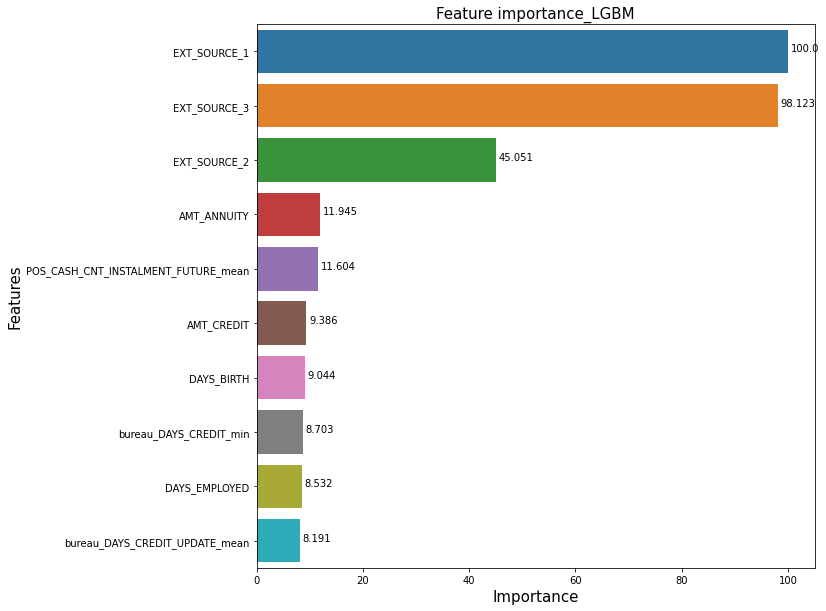

In [ ]:
plt.figure(figsize=(10,10))
ax=sns.barplot(y="features", x="importance", data=feature_importances_LGBM.head(10), orient='h')
ax.set_xlabel('Importance', fontsize=15)
ax.set_ylabel('Features', fontsize=15)
for p in ax.patches:
        x = p.get_x() + p.get_width() + 0.5
        y = p.get_y() + p.get_height()/2
        ax.annotate(round(p.get_width(),3), (x, y))

_=ax.set_title('Feature importance_LGBM', fontsize=15)

plt.savefig('feature importance.jpg')


# Suspicious EXT_SOURCES

Boosting tree based model gave an extremely high model evaluation matrices. The EXT_SOURCES highly dominated these model. These parameters are not clearly explained in the datasets. Hence, there is a possibility of data leakage, target might be wrongly incorporated into the EXT_SOURCES. Hence, I decided to build a model without these external sources.

# 3) Baseline Model without External sources

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone_two_final/Final_data/final_application_train_corr_0.98.csv')

# Variable separation: Features and Target
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3' ], axis=1).values
y=df['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
# Training the Logistic Regression model on the Training set
classifier_LR = LogisticRegression(random_state = 0)
classifier_LR.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_LR.predict(X_test)

# Model evaluation matrices
from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

#ROC_AUC Score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print('\n')
print('ROC_AUC Score:')
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))

Test Data Metrics:
[[56501     0]
 [ 4943     0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56501
           1       0.00      0.00      0.00      4943

    accuracy                           0.92     61444
   macro avg       0.46      0.50      0.48     61444
weighted avg       0.85      0.92      0.88     61444



Train Data Metrics:
[[225911      1]
 [ 19860      0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    225912
           1       0.00      0.00      0.00     19860

    accuracy                           0.92    245772
   macro avg       0.46      0.50      0.48    245772
weighted avg       0.84      0.92      0.88    245772



ROC_AUC Score:
roc_auc (test): 0.685
roc_auc (training): 0.678


**Baseline Model:** Roc_AUC(TEST)=0.685, the model evaluation matrices for 1 are zero.

# 4) Search for better Model

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone_two_final/Final_data/final_df_corr_0.98.csv')
df.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,...,FLAG_DOCUMENT_5_1,FLAG_DOCUMENT_6_1,FLAG_DOCUMENT_7_1,FLAG_DOCUMENT_8_1,FLAG_DOCUMENT_9_1,FLAG_DOCUMENT_10_1,FLAG_DOCUMENT_11_1,FLAG_DOCUMENT_12_1,FLAG_DOCUMENT_13_1,FLAG_DOCUMENT_14_1,FLAG_DOCUMENT_15_1,FLAG_DOCUMENT_16_1,FLAG_DOCUMENT_17_1,FLAG_DOCUMENT_18_1,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_1,most_frequent_bureau_CREDIT_ACTIVE_Closed,most_frequent_bureau_CREDIT_ACTIVE_Sold,most_frequent_bureau_CREDIT_CURRENCY_currency 2,most_frequent_bureau_CREDIT_CURRENCY_currency 3,most_frequent_bureau_CREDIT_TYPE_Car loan,most_frequent_bureau_CREDIT_TYPE_Consumer credit,most_frequent_bureau_CREDIT_TYPE_Credit card,most_frequent_bureau_CREDIT_TYPE_Loan for business development,most_frequent_bureau_CREDIT_TYPE_Microloan,most_frequent_bureau_CREDIT_TYPE_Mortgage,most_frequent_bureau_CREDIT_TYPE_Other,most_frequent_cc_balance_NAME_CONTRACT_STATUS_Completed,most_frequent_cc_balance_NAME_CONTRACT_STATUS_Demand,most_frequent_cc_balance_NAME_CONTRACT_STATUS_Signed,most_frequent_POS_NAME_CONTRACT_STATUS_Amortized debt,most_frequent_POS_NAME_CONTRACT_STATUS_Approved,most_frequent_POS_NAME_CONTRACT_STATUS_Completed,most_frequent_POS_NAME_CONTRACT_STATUS_Demand,most_frequent_POS_NAME_CONTRACT_STATUS_Returned to the store,most_frequent_POS_NAME_CONTRACT_STATUS_Signed,most_frequent_previous_app_NAME_CONTRACT_STATUS_Not Approved,most_frequent_previous_app_NAME_CLIENT_TYPE_Other,most_frequent_previous_app_NAME_CLIENT_TYPE_Repeater
0,100002,1,202500.0,406597.5,24700.5,0.018801,9461,637,3648.0,2120,0.0,10,0.083037,0.262949,0.139376,0.02470,0.036900,0.972200,0.619200,0.014300,0.000000,0.069000,0.083300,0.125000,0.036900,0.020200,0.019000,0.000000,0.00000,0.025200,0.038300,0.972200,0.014400,0.000000,0.069000,0.037700,0.022000,0.019800,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,270000.0,1293502.5,35698.5,0.003541,16765,1188,1186.0,291,0.0,11,0.311267,0.622246,0.521008,0.09590,0.052900,0.985100,0.796000,0.060500,0.080000,0.034500,0.291700,0.333300,0.013000,0.077300,0.054900,0.003900,0.00980,0.092400,0.053800,0.985100,0.049700,0.080600,0.034500,0.012800,0.079000,0.055400,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,100004,0,67500.0,135000.0,6750.0,0.010032,19046,225,4260.0,2531,26.0,9,0.511522,0.555912,0.729567,0.11746,0.088453,0.977731,0.752471,0.044619,0.078962,0.149741,0.226312,0.231916,0.066338,0.100787,0.107424,0.008811,0.02836,0.114249,0.087553,0.977061,0.042551,0.074508,0.145208,0.064962,0.105657,0.105999,0.008078,0.027024,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,0.008019,19005,3039,9833.0,2437,0.0,17,0.511522,0.650442,0.521008,0.11746,0.088453,0.977731,0.752471,0.044619,0.078962,0.149741,0.226312,0.231916,0.066338,0.100787,0.107424,0.008811,0.02836,0.114249,0.087553,0.977061,0.042551,0.074508,0.145208,0.064962,0.105657,0.105999,0.008078,0.027024,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,100007,0,121500.0,513000.0,21865.5,0.028663,19932,3038,4311.0,3458,0.0,11,0.511522,0.322738,0.521008,0.11746,0.088453,0.977731,0.752471,0.044619,0.078962,0.149741,0.226312,0.231916,0.066338,0.100787,0.107424,0.008811,0.02836,0.114249,0.087553,0.97

In [ ]:
# Variable separation: Features and Target
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3' ], axis=1).values
y=df['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

### 4.1) Logistic Regression

In [ ]:
# Training the Logistic Regression model on the Training set
classifier_LR = LogisticRegression(random_state = 0)
classifier_LR.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_LR.predict(X_test)

# Model evaluation matrices
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))


#ROC_AUC Score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print('\n')
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))

Test Data Metrics:
[[56459    42]
 [ 4898    45]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56501
           1       0.52      0.01      0.02      4943

    accuracy                           0.92     61444
   macro avg       0.72      0.50      0.49     61444
weighted avg       0.89      0.92      0.88     61444



Train Data Metrics:
[[225746    166]
 [ 19727    133]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    225912
           1       0.44      0.01      0.01     19860

    accuracy                           0.92    245772
   macro avg       0.68      0.50      0.49    245772
weighted avg       0.88      0.92      0.88    245772



roc_auc (test): 0.738
roc_auc (training): 0.731


In [ ]:
#Feature importance LR
feature_importance_LR=abs(classifier_LR.coef_)[0]
features= df.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).columns
feature_importances_LR=pd.DataFrame(list(zip(features,feature_importance_LR/max(feature_importance_LR)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LR.head(10)

,features,importance
47,count_bureau_CREDIT_ACTIVE_type_Active,100.000000
144,mean_count_bureau_balance_STATUS_type_1,47.528116
37,DEF_30_CNT_SOCIAL_CIRCLE,46.767478
38,DEF_60_CNT_SOCIAL_CIRCLE,46.190469
56,count_bureau_CREDIT_TYPE_type_Mortgage,43.041393
2,AMT_ANNUITY,42.133318
310,POS_CASH_CNT_INSTALMENT_FUTURE_sum,42.043973
266,installments_payments_NUM_INSTALMENT_VERSION_std,42.019164
269,installments_payments_NUM_INSTALMENT_NUMBER_me...,38.356295
270,installments_payments_NUM_INSTALMENT_NUMBER_max,36.752737


#### 4.1.1) weighted LR

In [ ]:
classifier_LR = LogisticRegression(random_state = 0, class_weight={0:1,1:10})
classifier_LR.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_LR.predict(X_test)
y_pred_train = classifier_LR.predict(X_train)

# Model Evaluation Metrices
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[40623 15878]
 [ 1835  3108]]
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56501
           1       0.16      0.63      0.26      4943

    accuracy                           0.71     61444
   macro avg       0.56      0.67      0.54     61444
weighted avg       0.89      0.71      0.78     61444



Train Data Metrics:
[[162650  63262]
 [  7582  12278]]
              precision    recall  f1-score   support

           0       0.96      0.72      0.82    225912
           1       0.16      0.62      0.26     19860

    accuracy                           0.71    245772
   macro avg       0.56      0.67      0.54    245772
weighted avg       0.89      0.71      0.78    245772

roc_auc (training): 0.733
roc_auc (test): 0.739


#### 4 .1.2) L1 Regularized LR

In [ ]:
classifier_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')
classifier_LR.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_LR.predict(X_test)
y_pred_train= classifier_LR.predict(X_train)


# Model Evaluation Metrices
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

#ROC_AUC Score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[41050 15451]
 [ 1816  3127]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56501
           1       0.17      0.63      0.27      4943

    accuracy                           0.72     61444
   macro avg       0.56      0.68      0.55     61444
weighted avg       0.89      0.72      0.78     61444



Train Data Metrics:
[[164427  61485]
 [  7408  12452]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83    225912
           1       0.17      0.63      0.27     19860

    accuracy                           0.72    245772
   macro avg       0.56      0.68      0.55    245772
weighted avg       0.89      0.72      0.78    245772

roc_auc (training): 0.743
roc_auc (test): 0.746


In [ ]:
feature_importances_LR=abs(classifier_LR.coef_)[0]
features= df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).columns
feature_importances_LR=pd.DataFrame(list(zip(features,feature_importances_LR/max(feature_importances_LR)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LR.head(10)

,features,importance
92,bureau_AMT_CREDIT_MAX_OVERDUE_var,100.000000
291,installments_payments_AMT_PAYMENT_min,94.657455
112,bureau_AMT_CREDIT_SUM_DEBT_var,52.795176
282,installments_payments_AMT_INSTALMENT_mean,51.658411
289,installments_payments_AMT_PAYMENT_mean,35.788552
91,bureau_AMT_CREDIT_MAX_OVERDUE_std,35.475669
272,installments_payments_NUM_INSTALMENT_NUMBER_sum,30.162013
290,installments_payments_AMT_PAYMENT_median,27.350495
274,installments_payments_NUM_INSTALMENT_NUMBER_var,27.081732
285,installments_payments_AMT_INSTALMENT_min,26.685145


#### 4.1.3) LR with elasticnet regularization

In [ ]:
classifier_LR = LogisticRegression(solver='saga', random_state = 0, class_weight={0:1,1:10}, penalty='elasticnet', l1_ratio=0.5)
classifier_LR.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_LR.predict(X_test)
y_pred_train=classifier_LR.predict(X_train)


# Model Evaluation Metrices
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


#ROC_AUC Score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[39545 16956]
 [ 1856  3087]]
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56501
           1       0.15      0.62      0.25      4943

    accuracy                           0.69     61444
   macro avg       0.55      0.66      0.53     61444
weighted avg       0.89      0.69      0.76     61444



Train Data Metrics:
[[158442  67470]
 [  7669  12191]]
              precision    recall  f1-score   support

           0       0.95      0.70      0.81    225912
           1       0.15      0.61      0.24     19860

    accuracy                           0.69    245772
   macro avg       0.55      0.66      0.53    245772
weighted avg       0.89      0.69      0.76    245772

roc_auc (training): 0.715
roc_auc (test): 0.723


### 4.2) Decision Tree

In [ ]:
classifier_DT = DecisionTreeClassifier(random_state = 0)
classifier_DT.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_DT.predict(X_test)


# Model Evaluation Metrices
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
y_pred_train=classifier_DT.predict(X_train)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


# ROC_AUC Score
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_DT.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[51273  5228]
 [ 4188   755]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     56501
           1       0.13      0.15      0.14      4943

    accuracy                           0.85     61444
   macro avg       0.53      0.53      0.53     61444
weighted avg       0.86      0.85      0.85     61444



Train Data Metrics:
[[225912      0]
 [     0  19860]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    225912
           1       1.00      1.00      1.00     19860

    accuracy                           1.00    245772
   macro avg       1.00      1.00      1.00    245772
weighted avg       1.00      1.00      1.00    245772

roc_auc (training): 1.000
roc_auc (test): 0.530


#### 4.2.1) Weighted DT

In [ ]:
classifier_DT = DecisionTreeClassifier(class_weight={0:1,1:10},random_state = 0)
classifier_DT.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_DT.predict(X_test)
y_pred_train=classifier_DT.predict(X_train)

# Confusion Matrix/classification Report
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

#ROC_AUC Score
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_DT.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

### 4.3) Random Forest classifier

In [ ]:
classifier_RF=RandomForestClassifier(random_state=0)
classifier_RF.fit(X_train,y_train)

# Predict the Test set results
y_pred = classifier_RF.predict(X_test)
y_pred_train=classifier_RF.predict(X_train)


# Model Evaluation Metrices
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_RF.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_RF.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[56493     8]
 [ 4930    13]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56501
           1       0.62      0.00      0.01      4943

    accuracy                           0.92     61444
   macro avg       0.77      0.50      0.48     61444
weighted avg       0.90      0.92      0.88     61444



Train Data Metrics:
[[225912      0]
 [     9  19851]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    225912
           1       1.00      1.00      1.00     19860

    accuracy                           1.00    245772
   macro avg       1.00      1.00      1.00    245772
weighted avg       1.00      1.00      1.00    245772

roc_auc (training): 1.000
roc_auc (test): 0.691


In [ ]:
#Feature importance RF
feature_importance_RF = classifier_RF.feature_importances_
features= df.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).columns
feature_importances_RF=pd.DataFrame(list(zip(features,feature_importance_RF/max(feature_importance_RF)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_RF.head(10)

,features,importance
4,DAYS_BIRTH,100.000000
6,DAYS_REGISTRATION,87.343366
7,DAYS_ID_PUBLISH,86.938028
63,bureau_DAYS_CREDIT_median,75.283757
2,AMT_ANNUITY,74.717844
5,DAYS_EMPLOYED,72.784280
62,bureau_DAYS_CREDIT_mean,72.176595
1,AMT_CREDIT,71.837366
39,DAYS_LAST_PHONE_CHANGE,71.757024
291,installments_payments_AMT_PAYMENT_min,71.493569


#### 4.3.1) Weighted RF

In [ ]:
classifier_RF=RandomForestClassifier(random_state=0, class_weight={0:1,1:10})
classifier_RF.fit(X_train,y_train)

# Predicting the Test set results
y_pred = classifier_RF.predict(X_test)
y_pred_train = classifier_RF.predict(X_train)


# Model Evaluation Metrices
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_RF.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_RF.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[56493     8]
 [ 4930    13]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56501
           1       0.62      0.00      0.01      4943

    accuracy                           0.92     61444
   macro avg       0.77      0.50      0.48     61444
weighted avg       0.90      0.92      0.88     61444



Train Data Metrics:
[[225912      0]
 [    13  19847]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    225912
           1       1.00      1.00      1.00     19860

    accuracy                           1.00    245772
   macro avg       1.00      1.00      1.00    245772
weighted avg       1.00      1.00      1.00    245772

roc_auc (training): 1.000
roc_auc (test): 0.709


### 4.4) AdaBoost Classifier

In [ ]:
classifier_AB = AdaBoostClassifier(random_state = 0)
classifier_AB.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_AB.predict(X_test)
y_pred_train = classifier_AB.predict(X_train)


# Model Evaluation Metrices
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_AB.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_AB.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[56452    49]
 [ 4896    47]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56501
           1       0.49      0.01      0.02      4943

    accuracy                           0.92     61444
   macro avg       0.70      0.50      0.49     61444
weighted avg       0.89      0.92      0.88     61444



Train Data Metrics:
[[225674    238]
 [ 19657    203]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    225912
           1       0.46      0.01      0.02     19860

    accuracy                           0.92    245772
   macro avg       0.69      0.50      0.49    245772
weighted avg       0.88      0.92      0.88    245772

roc_auc (training): 0.730
roc_auc (test): 0.733


### 4.5) Gradient boosting

In [ ]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1,2,5]

for learning_rate in lr_list:
    classifier_gb = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    classifier_gb.fit(X_train, y_train)


    print("Learning rate: ", learning_rate)
    y_pred_prob = classifier_gb.predict_proba(X_test)[:,1]
    y_pred_prob_train = classifier_gb.predict_proba(X_train)[:,1]
    print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
    print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))
    

classifier_gb = GradientBoostingClassifier(n_estimators=20, max_features=2, learning_rate=1, max_depth=2, random_state=0)
classifier_gb.fit(X_train, y_train)

y_pred_prob = classifier_gb.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_gb.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))
    

Learning rate:  0.05
roc_auc (training): 0.616
roc_auc (test): 0.627
Learning rate:  0.075
roc_auc (training): 0.617
roc_auc (test): 0.629
Learning rate:  0.1
roc_auc (training): 0.619
roc_auc (test): 0.630
Learning rate:  0.25
roc_auc (training): 0.625
roc_auc (test): 0.636
Learning rate:  0.5
roc_auc (training): 0.632
roc_auc (test): 0.645
Learning rate:  0.75
roc_auc (training): 0.635
roc_auc (test): 0.650
Learning rate:  1
roc_auc (training): 0.638
roc_auc (test): 0.653
Learning rate:  2
roc_auc (training): 0.617
roc_auc (test): 0.624
Learning rate:  5
roc_auc (training): 0.485
roc_auc (test): 0.480
roc_auc (training): 0.638
roc_auc (test): 0.653


### 4.6) XgBoost

In [ ]:
classifier_xgb = XGBClassifier(random_stat=0)
classifier_xgb.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_xgb.predict(X_test)
y_pred_train = classifier_xgb.predict(X_train)


# Model Evaluation Metrices
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_xgb.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_xgb.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[56497     4]
 [ 4939     4]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56501
           1       0.50      0.00      0.00      4943

    accuracy                           0.92     61444
   macro avg       0.71      0.50      0.48     61444
weighted avg       0.89      0.92      0.88     61444



Train Data Metrics:
[[225904      8]
 [ 19838     22]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    225912
           1       0.73      0.00      0.00     19860

    accuracy                           0.92    245772
   macro avg       0.83      0.50      0.48    245772
weighted avg       0.90      0.92      0.88    245772

roc_auc (training): 0.747
roc_auc (test): 0.744


### 4.7) Weighted XgBoost

In [ ]:
classifier_xgb = XGBClassifier(random_stat=0, scale_pos_weight=10)
classifier_xgb.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_xgb.predict(X_test)
y_pred_train = classifier_xgb.predict(X_train)


# Model Evaluation Metrices
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_xgb.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_xgb.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[42368 14133]
 [ 1951  2992]]
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     56501
           1       0.17      0.61      0.27      4943

    accuracy                           0.74     61444
   macro avg       0.57      0.68      0.56     61444
weighted avg       0.89      0.74      0.79     61444



Train Data Metrics:
[[169648  56264]
 [  7690  12170]]
              precision    recall  f1-score   support

           0       0.96      0.75      0.84    225912
           1       0.18      0.61      0.28     19860

    accuracy                           0.74    245772
   macro avg       0.57      0.68      0.56    245772
weighted avg       0.89      0.74      0.80    245772

roc_auc (training): 0.751
roc_auc (test): 0.746


### 4.8) LGBM

In [ ]:
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, roc_auc_score


#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#train the model 
classifier_LGBM=lgb.train({'scale_pos_weight': 10},d_train,100) #train the model on 100 epocs

#prediction on the test set
y_pred_prob=clf.predict(X_test)
y_pred_prob_train=clf.predict(X_train)


# Model Evaluation Metrices
y_pred= [1 if x >= 0.5 else 0 for x in y_pred_prob]
y_pred_train= [1 if x >= 0.5 else 0 for x in y_pred_prob_train]

print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print('\n')
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[44308 12193]
 [ 2180  2763]]
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     56501
           1       0.18      0.56      0.28      4943

    accuracy                           0.77     61444
   macro avg       0.57      0.67      0.57     61444
weighted avg       0.89      0.77      0.81     61444



Train Data Metrics:
[[177535  48377]
 [  8190  11670]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.86    225912
           1       0.19      0.59      0.29     19860

    accuracy                           0.77    245772
   macro avg       0.58      0.69      0.58    245772
weighted avg       0.89      0.77      0.82    245772



roc_auc (training): 0.765
roc_auc (test): 0.746


In [ ]:
feature_importance_LGBM = clf.feature_importance()
features= df.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).columns
feature_importances_LGBM=pd.DataFrame(list(zip(features,feature_importance_LGBM/max(feature_importance_LGBM)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LGBM.head(10)

,features,importance
1,AMT_CREDIT,100.000000
291,installments_payments_AMT_PAYMENT_min,96.268657
39,DAYS_LAST_PHONE_CHANGE,83.582090
5,DAYS_EMPLOYED,80.597015
4,DAYS_BIRTH,73.880597
307,POS_CASH_CNT_INSTALMENT_FUTURE_mean,65.671642
319,POS_CASH_SK_DPD_DEF_mean,60.447761
47,count_bureau_CREDIT_ACTIVE_type_Active,58.208955
337,CODE_GENDER_M,51.492537
106,bureau_AMT_CREDIT_SUM_DEBT_mean,47.014925


**As expected, all these models shews that the weighted models perfored better than the regular one. In addition, L1 regularized LR, xGBoost and LGBM are better than the other.** 

# 5) Models by resampling data to make a balanced dataset: Data resampled by SMOTE without including EXT_SOURCES


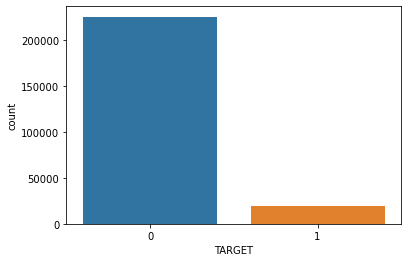

In [ ]:
df = pd.read_csv('Final_data/final_df_corr_0.98.csv')

X=df.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1)
y=df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
sns.countplot(pd.Series(y_train))

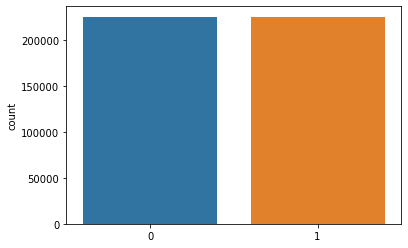

In [ ]:
sm = SMOTE(random_state = 101)

X_train_new, y_train_new = sm.fit_sample(X_train, y_train.ravel())

sns.countplot(pd.Series(y_train_new))

**Resampled data is well balanced.**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

X_train=scaler.fit_transform(X_train_new)
X_test=scaler.transform(X_test)
y_train=y_train_new

## 5.1) Regularized LR

In [ ]:
classifier_LR = LogisticRegression(solver='liblinear', random_state = 0, penalty='l1')
classifier_LR.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_LR.predict(X_test)


# Model Evaluation Metrices
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[38561 17940]
 [ 1575  3368]]
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56501
           1       0.16      0.68      0.26      4943

    accuracy                           0.68     61444
   macro avg       0.56      0.68      0.53     61444
weighted avg       0.90      0.68      0.75     61444



Train Data Metrics:
[[154150  71762]
 [ 65894 160018]]
              precision    recall  f1-score   support

           0       0.70      0.68      0.69    225912
           1       0.69      0.71      0.70    225912

    accuracy                           0.70    451824
   macro avg       0.70      0.70      0.70    451824
weighted avg       0.70      0.70      0.70    451824

roc_auc (training): 0.759
roc_auc (test): 0.745


In [ ]:
# feature importance LR
feature_importances_LR=abs(classifier_LR.coef_)[0]
features= df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).columns
feature_importances_LR=pd.DataFrame(list(zip(features,feature_importances_LR/max(feature_importances_LR)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LR.head(10)

,features,importance
291,installments_payments_AMT_PAYMENT_min,100.000000
92,bureau_AMT_CREDIT_MAX_OVERDUE_var,63.918681
282,installments_payments_AMT_INSTALMENT_mean,55.282144
112,bureau_AMT_CREDIT_SUM_DEBT_var,52.395836
289,installments_payments_AMT_PAYMENT_mean,36.116554
272,installments_payments_NUM_INSTALMENT_NUMBER_sum,32.292823
274,installments_payments_NUM_INSTALMENT_NUMBER_var,29.388871
290,installments_payments_AMT_PAYMENT_median,28.981783
105,bureau_AMT_CREDIT_SUM_var,23.972431
208,credit_card_balance_AMT_PAYMENT_CURRENT_min,23.131998


## 5.2) XGBoost

In [ ]:
classifier_xgb = XGBClassifier(random_stat=0)
classifier_xgb.fit(X_train, y_train)


# Predict the Test set results
y_pred = classifier_xgb.predict(X_test)


# Model Evaluation Metrices
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_xgb.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))


y_pred_prob = classifier_xgb.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_xgb.predict_proba(X_train)[:,1]
    
print('\n')
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))

[18:22:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { random_stat } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Test Data Metrics:
[[56238   263]
 [ 4783   160]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56501
           1       0.38      0.03      0.06      4943

    accuracy                           0.92     61444
   macro avg       0.65      0.51      0.51     61444
weighted avg       0.88      0.92      0.88     61444



Train Data Metrics:
[[225473    439]
 [ 18261 207651]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96    225912
           1       1.00      0.92      0.96    225912

    accuracy 

## 5.3) LGBM

In [ ]:
#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#train the model 
classifier_LGBM=lgb.train({'scale_pos_weight': 10},d_train,100) #train the model on 100 epocs

#prediction on the test set
y_pred=clf.predict(X_test)

y_pred=y_pred.round(0)
y_pred=y_pred.astype(int)

y_pred_train=clf.predict(X_train)
y_pred_train=y_pred_train.round(0)
y_pred_train=y_pred_train.astype(int)

# Model evaluation Metrices
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred)))

[[56465    36]
 [ 4934     9]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56501
           1       0.20      0.00      0.00      4943

    accuracy                           0.92     61444
   macro avg       0.56      0.50      0.48     61444
weighted avg       0.86      0.92      0.88     61444



Train Data Metrics:
[[225786    126]
 [ 21167 204745]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95    225912
           1       1.00      0.91      0.95    225912

    accuracy                           0.95    451824
   macro avg       0.96      0.95      0.95    451824
weighted avg       0.96      0.95      0.95    451824

roc_auc (training): 0.953
roc_auc (test): 0.501


In [ ]:
# feature importance LGBM
feature_importance_LGBM = clf.feature_importance()
features= df.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).columns
feature_importances_LGBM=pd.DataFrame(list(zip(features,feature_importance_LGBM/max(feature_importance_LGBM)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LGBM.head(10)

,features,importance
332,count_previous_app_NAME_CONTRACT_STATUS_type_N...,100.000000
36,OBS_30_CNT_SOCIAL_CIRCLE,68.907563
323,count_POS_NAME_CONTRACT_STATUS_type_Completed,22.689076
356,NAME_EDUCATION_TYPE_Higher education,21.568627
334,count_previous_app_NAME_CLIENT_TYPE_type_New,19.327731
359,NAME_EDUCATION_TYPE_Secondary,18.487395
357,NAME_EDUCATION_TYPE_Incomplete higher,17.647059
500,most_frequent_bureau_CREDIT_ACTIVE_Closed,17.086835
37,DEF_30_CNT_SOCIAL_CIRCLE,17.086835
46,count_bureau_CREDIT_ACTIVE_type_Closed,14.845938


# 6) Dimensionality reduction: PCA

In [ ]:
df = pd.read_csv('Final_data/final_df_corr_0.98.csv')
df.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,most_frequent_cc_balance_NAME_CONTRACT_STATUS_Signed,most_frequent_POS_NAME_CONTRACT_STATUS_Amortized debt,most_frequent_POS_NAME_CONTRACT_STATUS_Approved,most_frequent_POS_NAME_CONTRACT_STATUS_Completed,most_frequent_POS_NAME_CONTRACT_STATUS_Demand,most_frequent_POS_NAME_CONTRACT_STATUS_Returned to the store,most_frequent_POS_NAME_CONTRACT_STATUS_Signed,most_frequent_previous_app_NAME_CONTRACT_STATUS_Not Approved,most_frequent_previous_app_NAME_CLIENT_TYPE_Other,most_frequent_previous_app_NAME_CLIENT_TYPE_Repeater
0,100002,1,202500.0,406597.5,24700.5,0.018801,9461,637,3648.0,2120,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,270000.0,1293502.5,35698.5,0.003541,16765,1188,1186.0,291,...,0,0,0,0,0,0,0,0,1,0
2,100004,0,67500.0,135000.0,6750.0,0.010032,19046,225,4260.0,2531,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,0.008019,19005,3039,9833.0,2437,...,0,0,0,0,0,0,0,0,0,1
4,100007,0,121500.0,513000.0,21865.5,0.028663,19932,3038,4311.0,3458,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).values
y=df['TARGET'].values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X=scaler.fit_transform(X)

In [ ]:
pca = PCA(n_components=10)
principalComponents_df = pca.fit_transform(X)

print('Explained variation per principal components: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal components: [0.06729706 0.06174801 0.05117556 0.04686685 0.04055935 0.03451843
 0.0302898  0.02696171 0.02650794 0.02488631]


## 6.1) Visualization using two principal components 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents_df = pca.fit_transform(X)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.06729706 0.061748  ]


In [ ]:
principal_df = pd.DataFrame(data = principalComponents_df, columns = ['principal component 1', 'principal component 2'])
principal_df.tail()

,principal component 1,principal component 2
307211,-0.822873,2.030606
307212,0.466988,1.136022
307213,0.419278,0.847454
307214,0.003509,0.371752
307215,0.515967,0.415458


<Figure size 432x288 with 0 Axes>

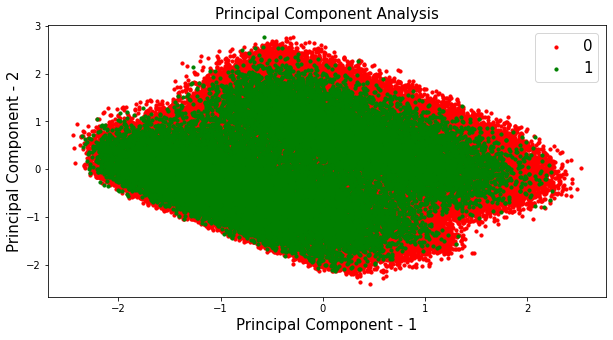

In [ ]:
plt.figure()
_=plt.figure(figsize=(10,5))
_=plt.xticks(fontsize=10)
_=plt.yticks(fontsize=10)
_=plt.xlabel('Principal Component - 1',fontsize=15)
_=plt.ylabel('Principal Component - 2',fontsize=15)
_=plt.title("Principal Component Analysis",fontsize=15)


targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = df['TARGET'] == target
    plt.scatter(principal_df.loc[indicesToKeep, 'principal component 1'], principal_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 10)

_=plt.legend(targets,prop={'size': 15})

**This shows that two class are not quite linearly separable when projected into two dimension, Tree based model might work best in this scenerio.**

## 6.2) LGBM Models using various PCs




### 6.2.1) LGBM using PCs=2

In [ ]:
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).values
y=df['TARGET'].values


from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X=scaler.fit_transform(X)


pca = PCA(n_components=2)
principalComponents_df = pca.fit_transform(X)



from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_test=scaler.transform(X_test)

from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test= pca.transform(X_test)


print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.0672814  0.06173943]


In [ ]:
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, roc_auc_score


#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#train the model 
classifier_LGBM=lgb.train({'scale_pos_weight': 10},d_train,100) #train the model on 100 epocs

#prediction on the test set
y_pred_prob=clf.predict(X_test)
y_pred_prob_train=clf.predict(X_train)

y_pred= [1 if x >= 0.5 else 0 for x in y_pred_prob]
y_pred_train= [1 if x >= 0.5 else 0 for x in y_pred_prob_train]

from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print('\n')
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[20475 36026]
 [ 1195  3748]]
              precision    recall  f1-score   support

           0       0.94      0.36      0.52     56501
           1       0.09      0.76      0.17      4943

    accuracy                           0.39     61444
   macro avg       0.52      0.56      0.35     61444
weighted avg       0.88      0.39      0.50     61444



Train Data Metrics:
[[167700  58212]
 [ 11406   8454]]
              precision    recall  f1-score   support

           0       0.94      0.74      0.83    225912
           1       0.13      0.43      0.20     19860

    accuracy                           0.72    245772
   macro avg       0.53      0.58      0.51    245772
weighted avg       0.87      0.72      0.78    245772



roc_auc (training): 0.632
roc_auc (test): 0.602


### 6.2.2) LGBM using PCs with explained varience >0.6

In [ ]:
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).values
y=df['TARGET'].values



from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X=scaler.fit_transform(X)


pca = PCA(n_components=2)
principalComponents_df = pca.fit_transform(X)



from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_test=scaler.transform(X_test)

from sklearn.decomposition import PCA
pca = PCA(0.6)
X_train = pca.fit_transform(X_train)
X_test= pca.transform(X_test)
print(pca.n_components_)


print('sum of explained variation is: {}'.format(np.sum(pca.explained_variance_ratio_)))


21
sum of explained variation is: 0.60365794485796


In [ ]:
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, roc_auc_score


#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#train the model 
classifier_LGBM=lgb.train({'scale_pos_weight': 10},d_train,100) #train the model on 100 epocs

#prediction on the test set
y_pred_prob=clf.predict(X_test)
y_pred_prob_train=clf.predict(X_train)

y_pred= [1 if x >= 0.5 else 0 for x in y_pred_prob]
y_pred_train= [1 if x >= 0.5 else 0 for x in y_pred_prob_train]

from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print('\n')
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[24857 31644]
 [ 1244  3699]]
              precision    recall  f1-score   support

           0       0.95      0.44      0.60     56501
           1       0.10      0.75      0.18      4943

    accuracy                           0.46     61444
   macro avg       0.53      0.59      0.39     61444
weighted avg       0.88      0.46      0.57     61444



Train Data Metrics:
[[173327  52585]
 [ 10314   9546]]
              precision    recall  f1-score   support

           0       0.94      0.77      0.85    225912
           1       0.15      0.48      0.23     19860

    accuracy                           0.74    245772
   macro avg       0.55      0.62      0.54    245772
weighted avg       0.88      0.74      0.80    245772



roc_auc (training): 0.689
roc_auc (test): 0.640


### 6.2.3) Model using PCs with explained varience >0.8

In [ ]:
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).values
y=df['TARGET'].values



from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X=scaler.fit_transform(X)


pca = PCA(n_components=2)
principalComponents_df = pca.fit_transform(X)



from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_test=scaler.transform(X_test)

from sklearn.decomposition import PCA
pca = PCA(0.8)
X_train = pca.fit_transform(X_train)
X_test= pca.transform(X_test)
print(pca.n_components_)


print('sum of explained variation is: {}'.format(np.sum(pca.explained_variance_ratio_)))

43
sum of explained variation is: 0.8020251922417508


In [ ]:
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, roc_auc_score


#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#train the model 
classifier_LGBM=lgb.train({'scale_pos_weight': 10},d_train,100) #train the model on 100 epocs

#prediction on the test set
y_pred_prob=clf.predict(X_test)
y_pred_prob_train=clf.predict(X_train)

y_pred= [1 if x >= 0.5 else 0 for x in y_pred_prob]
y_pred_train= [1 if x >= 0.5 else 0 for x in y_pred_prob_train]

from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print('\n')
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[42176 14325]
 [ 2706  2237]]
              precision    recall  f1-score   support

           0       0.94      0.75      0.83     56501
           1       0.14      0.45      0.21      4943

    accuracy                           0.72     61444
   macro avg       0.54      0.60      0.52     61444
weighted avg       0.87      0.72      0.78     61444



Train Data Metrics:
[[173438  52474]
 [  9506  10354]]
              precision    recall  f1-score   support

           0       0.95      0.77      0.85    225912
           1       0.16      0.52      0.25     19860

    accuracy                           0.75    245772
   macro avg       0.56      0.64      0.55    245772
weighted avg       0.88      0.75      0.80    245772



roc_auc (training): 0.715
roc_auc (test): 0.651


# 7) Best Models, Feature selection and Hyperparameter Tuning

**Analysis of model performance matrices shows LGBM and L1 regularized LR models are the best models.**

#### 7.1) LGBM

In [ ]:
df = pd.read_csv('Final_data/final_df_corr_0.98.csv')

X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)
y=df['TARGET']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, roc_auc_score

#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#train the model 
classifier_LGBM=lgb.train({'scale_pos_weight': 10},d_train,100) #train the model on 100 epocs

#prediction on the test set
y_pred_prob=clf.predict(X_test)
y_pred_prob_train=clf.predict(X_train)

y_pred= [1 if x >= 0.5 else 0 for x in y_pred_prob]
y_pred_train= [1 if x >= 0.5 else 0 for x in y_pred_prob_train]

from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print('\n')
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[44207 12176]
 [ 2379  2682]]
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     56383
           1       0.18      0.53      0.27      5061

    accuracy                           0.76     61444
   macro avg       0.56      0.66      0.56     61444
weighted avg       0.89      0.76      0.81     61444



Train Data Metrics:
[[178102  47928]
 [  8064  11678]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.86    226030
           1       0.20      0.59      0.29     19742

    accuracy                           0.77    245772
   macro avg       0.58      0.69      0.58    245772
weighted avg       0.90      0.77      0.82    245772



roc_auc (training): 0.768
roc_auc (test): 0.728


In [ ]:
feature_importance_LGBM = clf.feature_importance()
features= df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1).columns
feature_importances_LGBM=pd.DataFrame(list(zip(features,feature_importance_LGBM/max(feature_importance_LGBM)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LGBM.head(10)

,features,importance
1,AMT_CREDIT,100.000000
291,installments_payments_AMT_PAYMENT_min,87.323944
39,DAYS_LAST_PHONE_CHANGE,78.873239
5,DAYS_EMPLOYED,73.239437
319,POS_CASH_SK_DPD_DEF_mean,67.605634
4,DAYS_BIRTH,58.450704
106,bureau_AMT_CREDIT_SUM_DEBT_mean,54.929577
337,CODE_GENDER_M,50.704225
307,POS_CASH_CNT_INSTALMENT_FUTURE_mean,50.704225
47,count_bureau_CREDIT_ACTIVE_type_Active,49.295775


In [ ]:
to_drop_1=feature_importances_LGBM[feature_importances_LGBM['importance']==0]['features'].values.tolist()
print('No. of features to drop:{}'.format(len(to_drop_1)))

No. of features to drop:326


In [ ]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307216 entries, 0 to 307215
Data columns (total 528 columns):
 #   Column                                                          Non-Null Count   Dtype  
---  ------                                                          --------------   -----  
 0   SK_ID_CURR                                                      307216 non-null  int64  
 1   TARGET                                                          307216 non-null  int64  
 2   AMT_INCOME_TOTAL                                                307216 non-null  float64
 3   AMT_CREDIT                                                      307216 non-null  float64
 4   AMT_ANNUITY                                                     307216 non-null  float64
 5   REGION_POPULATION_RELATIVE                                      307216 non-null  float64
 6   DAYS_BIRTH                                                      307216 non-null  int64  
 7   DAYS_EMPLOYED                        

In [ ]:
not_to_drop_1=feature_importances_LGBM[feature_importances_LGBM['importance']>0]['features'].values.tolist()
print('No. of features not to drop:{}'.format(len(not_to_drop_1)))

No. of features not to drop:197


In [ ]:
df1=df.drop(to_drop_1, axis=1)
df1=df1.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)
df1.to_csv('Final_data/df including more than 0% feature importances_LGBM_without Ext source.csv',index=False)

##### Rechecking model after feature selection

In [ ]:
#df1 = pd.read_csv('submission/df including more than 0% feature importances_LGBM_without Ext source.csv')
X=df1.drop(['TARGET','SK_ID_CURR'], axis=1)
y=df1['TARGET']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, roc_auc_score

#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#train the model 
classifier_LGBM=lgb.train({'scale_pos_weight': 10},d_train,100) #train the model on 100 epocscs

#prediction on the test set
y_pred_prob=clf.predict(X_test)
y_pred_prob_train=clf.predict(X_train)

y_pred= [1 if x >= 0.5 else 0 for x in y_pred_prob]
y_pred_train= [1 if x >= 0.5 else 0 for x in y_pred_prob_train]

from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print('\n')
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[44310 12111]
 [ 2283  2740]]
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     56421
           1       0.18      0.55      0.28      5023

    accuracy                           0.77     61444
   macro avg       0.57      0.67      0.57     61444
weighted avg       0.89      0.77      0.81     61444



Train Data Metrics:
[[177843  48149]
 [  8195  11585]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.86    225992
           1       0.19      0.59      0.29     19780

    accuracy                           0.77    245772
   macro avg       0.57      0.69      0.58    245772
weighted avg       0.89      0.77      0.82    245772



roc_auc (training): 0.766
roc_auc (test): 0.738


**The roc_auc remains almost similar after selected features.**

##### Grid search/Randomised Search

**Starting Model**

In [ ]:
df = pd.read_csv('Final_data/df including more than 0% feature importances_LGBM_without Ext source.csv')
df=df.sample(frac=0.5,random_state=0)


X=df.drop(['TARGET','SK_ID_CURR'], axis=1)
y=df['TARGET']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


#### LGBM
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, roc_auc_score


#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#train the model 
classifier_LGBM=lgb.train({'scale_pos_weight': 10},d_train,100) #train the model on 100 epocs

#prediction on the test set
y_pred_prob=clf.predict(X_test)
y_pred_prob_train=clf.predict(X_train)

y_pred= [1 if x >= 0.5 else 0 for x in y_pred_prob]
y_pred_train= [1 if x >= 0.5 else 0 for x in y_pred_prob_train]

from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print('\n')
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[22174  6097]
 [ 1100  1351]]
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     28271
           1       0.18      0.55      0.27      2451

    accuracy                           0.77     30722
   macro avg       0.57      0.67      0.57     30722
weighted avg       0.89      0.77      0.81     30722



Train Data Metrics:
[[88987 23905]
 [ 3771  6223]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.87    112892
           1       0.21      0.62      0.31      9994

    accuracy                           0.77    122886
   macro avg       0.58      0.71      0.59    122886
weighted avg       0.90      0.77      0.82    122886



roc_auc (training): 0.787
roc_auc (test): 0.738


In [ ]:
#GRidSearch CV
param_grid = {
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25,50,100],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [0, 1, 2.5, 5, 10,15,20],
    'reg_lambda': [0,1,2.5,5,10,15,20],
    'min_split_gain': [0.3, 0.4, 0.8,1, 1.5],
    'scale_pos_weight':[5,8,9,10,11,12,15,20,50,100],
    'subsample': [0.5, 0.8, 0.9],
    'subsample_freq': [10,20,30,40],
    'learning_rate':[0.01,0.03,0.05,0.1,0.3,0.5,1]}
    
import lightgbm as lgb

gsearch = GridSearchCV(estimator = lgb.LGBMClassifier(random_state=0), param_grid = param_grid, scoring='roc_auc', cv=5)
gsearch.fit(X_train,y_train)
gsearch.best_params_, gsearch.best_score_

**GRidsearch CV is computationally intensive.**

In [ ]:
# Randomized CV
param_grid = {
    'n_estimators':list(np.arange(150,200,2)),
   'colsample_bytree': list(np.linspace(0,1,11)),
    'max_depth': list(np.arange(10,100,5)),
    'num_leaves': list(np.arange(25, 100, 25)),
    'reg_alpha': [0, 1, 2.5, 5, 10,15,20],
    'reg_lambda': [0,1,2.5,5,10,15,20],
    'min_split_gain': [0.3, 0.4, 0.8,1.5],
    'scale_pos_weight':[7,8,9,10,11,12,13,14,15],
    'subsample': list(np.arange(0.2,1,0.1)),
    'subsample_freq': list(np.arange(10,50,5))}


import lightgbm as lgb

clf = lgb.LGBMClassifier(random_state=0, learning_rate=0.05)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_grid, 
    n_iter=500,
    scoring='roc_auc',
    cv=5,
    refit=True,
    random_state=0,
    verbose=True)



# Fit the object to our data
gs.fit(X_train, y_train)


print(gs.best_score_)
print(gs.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed: 352.7min finished


0.7415161040771403
{'subsample_freq': 10, 'subsample': 0.9000000000000001, 'scale_pos_weight': 7, 'reg_lambda': 15, 'reg_alpha': 10, 'num_leaves': 25, 'n_estimators': 194, 'min_split_gain': 0.3, 'max_depth': 75, 'colsample_bytree': 0.5}


####  7.2) Regularized LR

In [ ]:
df = pd.read_csv('Final_data/final_df_corr_0.98.csv')

X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)
y=df['TARGET']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')
classifier_LR.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier_LR.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[41199 15222]
 [ 1881  3142]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56421
           1       0.17      0.63      0.27      5023

    accuracy                           0.72     61444
   macro avg       0.56      0.68      0.55     61444
weighted avg       0.89      0.72      0.78     61444



Train Data Metrics:
[[164884  61108]
 [  7404  12376]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83    225992
           1       0.17      0.63      0.27     19780

    accuracy                           0.72    245772
   macro avg       0.56      0.68      0.55    245772
weighted avg       0.89      0.72      0.78    245772

roc_auc (training): 0.744
roc_auc (test): 0.741


In [ ]:
feature_importance_LR=abs(classifier_LR.coef_)[0]
features= df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1).columns
feature_importances_LR=pd.DataFrame(list(zip(features,feature_importance_LR/max(feature_importance_LR)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LR.head(10)

,features,importance
291,installments_payments_AMT_PAYMENT_min,100.000000
92,bureau_AMT_CREDIT_MAX_OVERDUE_var,97.370284
282,installments_payments_AMT_INSTALMENT_mean,78.228313
112,bureau_AMT_CREDIT_SUM_DEBT_var,69.882895
289,installments_payments_AMT_PAYMENT_mean,52.943491
91,bureau_AMT_CREDIT_MAX_OVERDUE_std,34.905053
209,credit_card_balance_AMT_PAYMENT_CURRENT_sum,33.229722
272,installments_payments_NUM_INSTALMENT_NUMBER_sum,31.987363
126,bureau_AMT_CREDIT_SUM_OVERDUE_var,28.061540
110,bureau_AMT_CREDIT_SUM_DEBT_sum,27.407903


In [ ]:
to_drop=feature_importances_LR[feature_importances_LR['importance']<.05]['features'].values.tolist()
print('No. of features to drop: {}'.format(len(to_drop)))

No. of features to drop: 103


In [ ]:
df2=df.drop(to_drop, axis=1)
df2=df2.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)
df2.to_csv('Final_data/df including 0.5% feature importances_LR_without Ext source.csv',index=False)

##### Rechecking model using selected features

In [ ]:
#df = pd.read_csv('Final_data/df including 0.5% feature importances_LR_without Ext source.csv')

X=df2.drop(['TARGET','SK_ID_CURR'], axis=1)
y=df2['TARGET']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')
classifier_LR.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier_LR.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[41034 15467]
 [ 1791  3152]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56501
           1       0.17      0.64      0.27      4943

    accuracy                           0.72     61444
   macro avg       0.56      0.68      0.55     61444
weighted avg       0.89      0.72      0.78     61444



Train Data Metrics:
[[164375  61537]
 [  7417  12443]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83    225912
           1       0.17      0.63      0.27     19860

    accuracy                           0.72    245772
   macro avg       0.56      0.68      0.55    245772
weighted avg       0.89      0.72      0.78    245772

roc_auc (training): 0.743
roc_auc (test): 0.747


In [ ]:
# Fraction of Data
df = pd.read_csv('Final_data/df including 0.5% feature importances_LR_without Ext source.csv')
dff=df.sample(frac=0.25, random_state=0)

X=dff.drop(['TARGET','SK_ID_CURR'], axis=1)
y=dff['TARGET']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')
classifier_LR.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier_LR.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[10231  3829]
 [  521   780]]
              precision    recall  f1-score   support

           0       0.95      0.73      0.82     14060
           1       0.17      0.60      0.26      1301

    accuracy                           0.72     15361
   macro avg       0.56      0.66      0.54     15361
weighted avg       0.89      0.72      0.78     15361



Train Data Metrics:
[[41500 14987]
 [ 1754  3202]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56487
           1       0.18      0.65      0.28      4956

    accuracy                           0.73     61443
   macro avg       0.57      0.69      0.55     61443
weighted avg       0.90      0.73      0.79     61443

roc_auc (training): 0.758
roc_auc (test): 0.724


**Model evaluation matrices follows a similar trend with selected feature and fraction of Data. Hence, these frac of data for Grid SearchCV.**

#####  RandomSearch CV

**Starting Model**

In [ ]:
#df = pd.read_csv('Final_data/df including 0.5% feature importances_LR_without Ext source.csv')

X=df2.drop(['TARGET','SK_ID_CURR'], axis=1)
y=df2['TARGET']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')
classifier_LR.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier_LR.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[41034 15467]
 [ 1791  3152]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56501
           1       0.17      0.64      0.27      4943

    accuracy                           0.72     61444
   macro avg       0.56      0.68      0.55     61444
weighted avg       0.89      0.72      0.78     61444



Train Data Metrics:
[[164375  61537]
 [  7417  12443]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83    225912
           1       0.17      0.63      0.27     19860

    accuracy                           0.72    245772
   macro avg       0.56      0.68      0.55    245772
weighted avg       0.89      0.72      0.78    245772

roc_auc (training): 0.743
roc_auc (test): 0.747


In [ ]:
#RandomSearch CV
w = [{0:1,1:5},{0:1,1:7.5}, {0:1,1:10}, {0:1,1:12.5},{0:1,1:15}, {0:1,1:6},{0:1,1:7},{0:1,1:8}, {0:1,1:9}, {0:1,1:11},{0:1,1:12}, {0:1,1:13}, {0:1,1:14},{0:1,1:15}]

param_grid = {
    "class_weight": w,
    "C": list(np.arange(0,3,0.25))
}


from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')

rs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_grid, 
    n_iter=500,
    scoring='roc_auc',
    cv=5,
    refit=True,
    random_state=0,
    verbose=True)



# Fit the object to our data
rs.fit(X_train, y_train)


print(rs.best_score_)
print(rs.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 37.0min finished


0.7023865766546925
{'class_weight': {0: 1, 1: 5}, 'C': 1.0}


# 8) Final Models

In [2]:
df = pd.read_csv('Final_data/final_df_corr_0.98.csv')
df.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,most_frequent_cc_balance_NAME_CONTRACT_STATUS_Signed,most_frequent_POS_NAME_CONTRACT_STATUS_Amortized debt,most_frequent_POS_NAME_CONTRACT_STATUS_Approved,most_frequent_POS_NAME_CONTRACT_STATUS_Completed,most_frequent_POS_NAME_CONTRACT_STATUS_Demand,most_frequent_POS_NAME_CONTRACT_STATUS_Returned to the store,most_frequent_POS_NAME_CONTRACT_STATUS_Signed,most_frequent_previous_app_NAME_CONTRACT_STATUS_Not Approved,most_frequent_previous_app_NAME_CLIENT_TYPE_Other,most_frequent_previous_app_NAME_CLIENT_TYPE_Repeater
0,100002,1,202500.0,406597.5,24700.5,0.018801,9461,637,3648.0,2120,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,270000.0,1293502.5,35698.5,0.003541,16765,1188,1186.0,291,...,0,0,0,0,0,0,0,0,1,0
2,100004,0,67500.0,135000.0,6750.0,0.010032,19046,225,4260.0,2531,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,0.008019,19005,3039,9833.0,2437,...,0,0,0,0,0,0,0,0,0,1
4,100007,0,121500.0,513000.0,21865.5,0.028663,19932,3038,4311.0,3458,...,0,0,0,0,0,0,0,0,0,1


###### LR

In [3]:
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)
y=df['TARGET']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:6}, penalty='l1', C=0.5)
classifier_LR.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier_LR.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))


from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print('\n')
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))


Test Data Metrics:
[[49795  6626]
 [ 3084  1939]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     56421
           1       0.23      0.39      0.29      5023

    accuracy                           0.84     61444
   macro avg       0.58      0.63      0.60     61444
weighted avg       0.88      0.84      0.86     61444



Train Data Metrics:
[[199227  26765]
 [ 11929   7851]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91    225992
           1       0.23      0.40      0.29     19780

    accuracy                           0.84    245772
   macro avg       0.59      0.64      0.60    245772
weighted avg       0.89      0.84      0.86    245772



roc_auc (test): 0.740
roc_auc (training): 0.742


In [13]:
# Predicting the Test set results
y_pred = classifier_LR.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))


from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print('\n')
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))


Test Data Metrics:
[[49795  6626]
 [ 3084  1939]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     56421
           1       0.23      0.39      0.29      5023

    accuracy                           0.84     61444
   macro avg       0.58      0.63      0.60     61444
weighted avg       0.88      0.84      0.86     61444



Train Data Metrics:
[[199227  26765]
 [ 11929   7851]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91    225992
           1       0.23      0.40      0.29     19780

    accuracy                           0.84    245772
   macro avg       0.59      0.64      0.60    245772
weighted avg       0.89      0.84      0.86    245772



roc_auc (test): 0.740
roc_auc (training): 0.742


In [4]:
feature_importance_LR=abs(classifier_LR.coef_)[0]
features= df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1).columns
feature_importances_LR=pd.DataFrame(list(zip(features,feature_importance_LR/max(feature_importance_LR)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LR.head(10)

,features,importance
291,installments_payments_AMT_PAYMENT_min,100.000000
272,installments_payments_NUM_INSTALMENT_NUMBER_sum,34.781679
289,installments_payments_AMT_PAYMENT_mean,31.309347
110,bureau_AMT_CREDIT_SUM_DEBT_sum,28.468867
282,installments_payments_AMT_INSTALMENT_mean,27.858136
274,installments_payments_NUM_INSTALMENT_NUMBER_var,27.153778
209,credit_card_balance_AMT_PAYMENT_CURRENT_sum,26.714690
112,bureau_AMT_CREDIT_SUM_DEBT_var,20.161101
322,count_POS_NAME_CONTRACT_STATUS_type_Active,19.169655
44,AMT_REQ_CREDIT_BUREAU_QRT,18.398242


##### LGBM

In [5]:
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)
y=df['TARGET']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


import lightgbm as lgb

#converting the dataset into proper LGB format 
train_set = lgb.Dataset(data = X_train, label = y_train)


#Specifying the parameter
params={}
params['learning_rate']=0.05
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Binary target feature
params['metric']='binary_logloss' #metric for binary classification
params['max_depth']=75
params['subsample_freq']= 10, 
params['subsample']= 0.9,
params['scale_pos_weight']=7, 
params['reg_lambda']=15, 
params['reg_alpha']=10, 
params['num_leaves']= 25,
params['min_split_gain']= 0.3,
params['colsample_bytree']= 0.5,
params['scale_pos_weight']= 8,


#train the model 
clf_lgbm=lgb.train(params,train_set,194)

#prediction on the test set
y_pred_prob=clf_lgbm.predict(X_test)
y_pred_prob_train=clf_lgbm.predict(X_train)

y_pred= [1 if x >= 0.5 else 0 for x in y_pred_prob]
y_pred_train= [1 if x >= 0.5 else 0 for x in y_pred_prob_train]

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

from sklearn.metrics import roc_auc_score
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

[[46449  9972]
 [ 2435  2588]]
              precision    recall  f1-score   support

           0       0.95      0.82      0.88     56421
           1       0.21      0.52      0.29      5023

    accuracy                           0.80     61444
   macro avg       0.58      0.67      0.59     61444
weighted avg       0.89      0.80      0.83     61444



Train Data Metrics:
[[186951  39041]
 [  8502  11278]]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89    225992
           1       0.22      0.57      0.32     19780

    accuracy                           0.81    245772
   macro avg       0.59      0.70      0.60    245772
weighted avg       0.90      0.81      0.84    245772

roc_auc (training): 0.789
roc_auc (test): 0.754


In [8]:
feature_importance_LGBM = clf_lgbm.feature_importance()
features= df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1).columns
feature_importances_LGBM=pd.DataFrame(list(zip(features,feature_importance_LGBM/max(feature_importance_LGBM)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LGBM.head(10)

,features,importance
1,AMT_CREDIT,100.000000
2,AMT_ANNUITY,63.333333
291,installments_payments_AMT_PAYMENT_min,61.666667
39,DAYS_LAST_PHONE_CHANGE,60.555556
307,POS_CASH_CNT_INSTALMENT_FUTURE_mean,50.555556
4,DAYS_BIRTH,50.000000
7,DAYS_ID_PUBLISH,48.333333
5,DAYS_EMPLOYED,47.222222
106,bureau_AMT_CREDIT_SUM_DEBT_mean,39.444444
65,bureau_DAYS_CREDIT_min,38.333333


#### Most influential Features

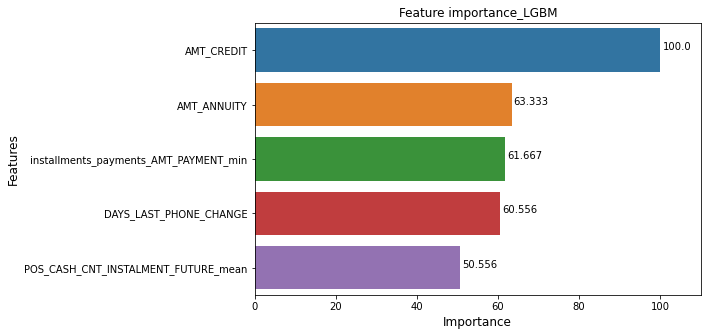

In [11]:
plt.figure(figsize=(8,5))
ax=sns.barplot(y="features", x="importance", data=feature_importances_LGBM.head(5), orient='h')
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_xlim([0,110])
for p in ax.patches:
        x = p.get_x() + p.get_width() + 0.5
        y = p.get_y() + p.get_height()/2
        ax.annotate(round(p.get_width(),3), (x, y))

_=ax.set_title('Feature importance_LGBM', fontsize=12)

#### Classification report and confusion Matrix

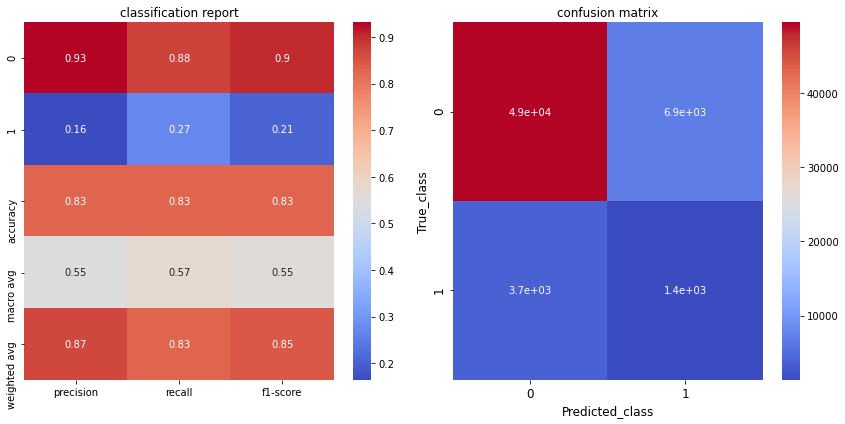

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()

f,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
sns.heatmap(report.drop('support',axis=1), annot=True, cmap="coolwarm", ax=ax1)
ax1.set_title('classification report')

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="coolwarm", ax=ax2)
ax2.tick_params(labelsize=12)
ax2.set_xlabel('Predicted_class', size=12)
ax2.set_ylabel('True_class', size=12)
ax2.set_title('confusion matrix')


plt.tight_layout()

plt.savefig('evaluation')


# Final analysis

##### With Ext Sources

In [3]:
df1 = pd.read_csv('Final_data/final_application_train_corr_0.98.csv')
df = pd.read_csv('Final_data/final_df_corr_0.98.csv')

In [13]:
#Baseline
# Variable separation: Features and Target
X=df1.drop(['TARGET','SK_ID_CURR'], axis=1).values
y=df1['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_test1=X_test.copy()


# Train the Logistic Regression model on the Training set
classifier_Baseline_LR = LogisticRegression(random_state = 0)
classifier_Baseline_LR.fit(X_train, y_train)


#Better model
# Variable separation: Features and Target
X=df.drop(['TARGET','SK_ID_CURR'], axis=1).values
y=df['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


# Train the Logistic Regression model on the Training set
classifier_LR = LogisticRegression(random_state = 0, class_weight={0:1,1:10})
classifier_LR.fit(X_train, y_train)

classifier_L1_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')
classifier_L1_LR.fit(X_train, y_train)

classifier_DT = DecisionTreeClassifier(class_weight={0:1,1:10},random_state = 0)
classifier_DT.fit(X_train, y_train)

classifier_RF=RandomForestClassifier(random_state=0, class_weight={0:1,1:10})
classifier_RF.fit(X_train,y_train)

classifier_AB = AdaBoostClassifier(random_state = 0)
classifier_AB.fit(X_train, y_train)

classifier_xgb = XGBClassifier(random_stat=0, scale_pos_weight=10)
classifier_xgb.fit(X_train, y_train)


#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#train the model 
classifier_LGBM=lgb.train({'scale_pos_weight': 10},d_train,100) #train the model on 100 epocs

[02:14:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { random_stat } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [37]:
#Better model
# Variable separation: Features and Target
X=df.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).values
y=df['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#train the model 
classifier_LGBM=lgb.train({'scale_pos_weight': 10},d_train,100) #train the model on 100 epocs

In [38]:
y_pred_prob8=classifier_LGBM.predict(X_test)
fpr8 , tpr8, thresholds8 = roc_curve(y_test, y_pred_prob8)
roc_auc_score(y_test, y_pred_prob8)

0.7523521709370687

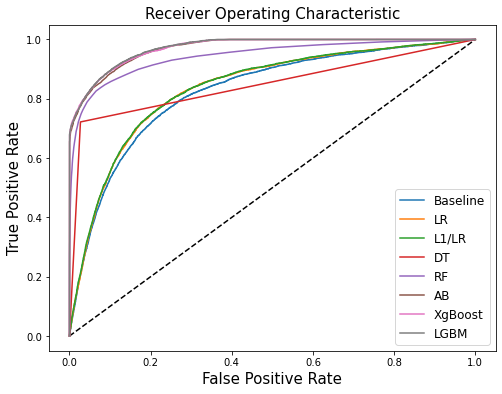

In [14]:
#ROC Curve
from sklearn.metrics import roc_curve
plt.figure(figsize=(8,6))

y_pred_prob1 = classifier_Baseline_LR.predict_proba(X_test1)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test1, y_pred_prob1)

y_pred_prob2 = classifier_LR.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)


y_pred_prob3 = classifier_L1_LR.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)

y_pred_prob4 = classifier_DT.predict_proba(X_test)[:,1]
fpr4 , tpr4, thresholds4 = roc_curve(y_test, y_pred_prob4)

y_pred_prob5 = classifier_RF.predict_proba(X_test)[:,1]
fpr5 , tpr5, thresholds5 = roc_curve(y_test, y_pred_prob5)


y_pred_prob6 = classifier_AB.predict_proba(X_test)[:,1]
fpr6 , tpr6, thresholds6 = roc_curve(y_test, y_pred_prob6)

y_pred_prob7 = classifier_xgb.predict_proba(X_test)[:,1]
fpr7 , tpr7, thresholds7 = roc_curve(y_test, y_pred_prob7)

y_pred_prob8=classifier_LGBM.predict(X_test)
fpr8 , tpr8, thresholds8 = roc_curve(y_test, y_pred_prob8)




plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Baseline")
plt.plot(fpr2, tpr2, label= "LR")
plt.plot(fpr3, tpr3, label= "L1/LR")
plt.plot(fpr4, tpr4, label= "DT")
plt.plot(fpr5, tpr5, label= "RF")
plt.plot(fpr6, tpr6, label= "AB")
plt.plot(fpr7, tpr7, label= "XgBoost")
plt.plot(fpr8, tpr8, label= "LGBM")


plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('Receiver Operating Characteristic', fontsize=15)
plt.show()

In [34]:
Models=['Baseline','LR','L1/LR', 'DT', 'RF', 'AdaBoost','XgBoost', 'LGBM']
df_score=pd.DataFrame(Models, columns=['Models'])
score=[roc_auc_score(y_test1, y_pred_prob1),roc_auc_score(y_test, y_pred_prob2),roc_auc_score(y_test, y_pred_prob3),roc_auc_score(y_test, y_pred_prob4),roc_auc_score(y_test, y_pred_prob5),roc_auc_score(y_test, y_pred_prob6),roc_auc_score(y_test, y_pred_prob7),roc_auc_score(y_test, y_pred_prob8)]
df_score['score']=score
df_score['score']=df_score['score'].apply(lambda x:np.round(x,3))
df_score

,Models,score
0,Baseline,0.825
1,LR,0.836
2,L1/LR,0.837
3,DT,0.847
4,RF,0.944
5,AdaBoost,0.971
6,XgBoost,0.972
7,LGBM,0.972


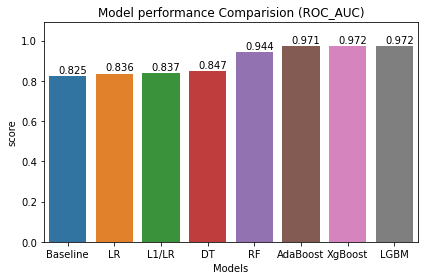

In [35]:
plt.figure(figsize=(6,4))
ax=sns.barplot(x='Models',y='score',data=df_score)
plt.ylim([0,1.09])
plt.title('Model performance Comparision (ROC_AUC)')

for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+0.015))
plt.tight_layout()


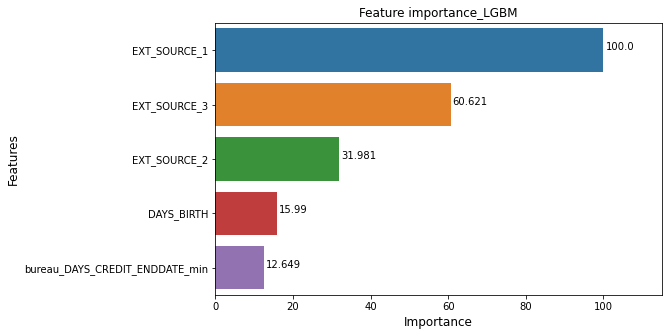

In [36]:
feature_importance_LGBM = classifier_LGBM.feature_importance()
features= df.drop(['TARGET','SK_ID_CURR'], axis=1).columns
feature_importances_LGBM=pd.DataFrame(list(zip(features,feature_importance_LGBM/max(feature_importance_LGBM)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LGBM.head(10)

plt.figure(figsize=(8,5))
ax=sns.barplot(y="features", x="importance", data=feature_importances_LGBM.head(5), orient='h')
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_xlim([0,115])
for p in ax.patches:
        x = p.get_x() + p.get_width() + 0.5
        y = p.get_y() + p.get_height()/2
        ax.annotate(round(p.get_width(),3), (x, y))

_=ax.set_title('Feature importance_LGBM', fontsize=12)


##### Excluding Ext sources

In [18]:
#Baseline
# Variable separation: Features and Target
X=df1.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).values
y=df1['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_test1=X_test.copy()
y_test1=y_test.copy()


# Train the Logistic Regression model on the Training set
classifier_Baseline_LR = LogisticRegression(random_state = 0)
classifier_Baseline_LR.fit(X_train, y_train)


#Better model
# Variable separation: Features and Target
X=df.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).values
y=df['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


# Train the Logistic Regression model on the Training set
classifier_LR = LogisticRegression(random_state = 0, class_weight={0:1,1:10})
classifier_LR.fit(X_train, y_train)

classifier_L1_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')
classifier_L1_LR.fit(X_train, y_train)

classifier_DT = DecisionTreeClassifier(class_weight={0:1,1:10},random_state = 0)
classifier_DT.fit(X_train, y_train)

classifier_RF=RandomForestClassifier(random_state=0, class_weight={0:1,1:10})
classifier_RF.fit(X_train,y_train)

classifier_AB = AdaBoostClassifier(random_state = 0)
classifier_AB.fit(X_train, y_train)

classifier_xgb = XGBClassifier(random_stat=0, scale_pos_weight=10)
classifier_xgb.fit(X_train, y_train)


#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

#train the model 
classifier_LGBM=lgb.train({'scale_pos_weight': 10},d_train,100) #train the model on 100 epocs

[19:18:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { random_stat } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




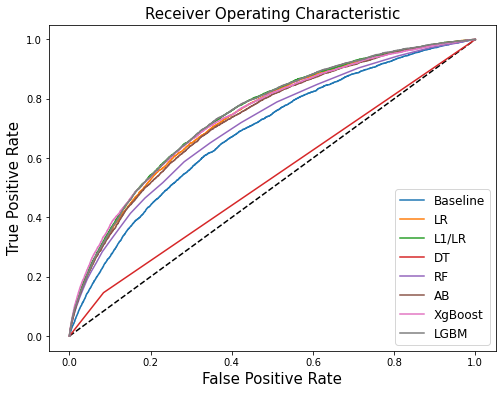

In [19]:
#ROC Curve
from sklearn.metrics import roc_curve
plt.figure(figsize=(8,6))

y_pred_prob1 = classifier_Baseline_LR.predict_proba(X_test1)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test1, y_pred_prob1)

y_pred_prob2 = classifier_LR.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)


y_pred_prob3 = classifier_L1_LR.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)

y_pred_prob4 = classifier_DT.predict_proba(X_test)[:,1]
fpr4 , tpr4, thresholds4 = roc_curve(y_test, y_pred_prob4)

y_pred_prob5 = classifier_RF.predict_proba(X_test)[:,1]
fpr5 , tpr5, thresholds5 = roc_curve(y_test, y_pred_prob5)


y_pred_prob6 = classifier_AB.predict_proba(X_test)[:,1]
fpr6 , tpr6, thresholds6 = roc_curve(y_test, y_pred_prob6)

y_pred_prob7 = classifier_xgb.predict_proba(X_test)[:,1]
fpr7 , tpr7, thresholds7 = roc_curve(y_test, y_pred_prob7)

y_pred_prob8=classifier_LGBM.predict(X_test)
fpr8 , tpr8, thresholds8 = roc_curve(y_test, y_pred_prob8)




plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Baseline")
plt.plot(fpr2, tpr2, label= "LR")
plt.plot(fpr3, tpr3, label= "L1/LR")
plt.plot(fpr4, tpr4, label= "DT")
plt.plot(fpr5, tpr5, label= "RF")
plt.plot(fpr6, tpr6, label= "AB")
plt.plot(fpr7, tpr7, label= "XgBoost")
plt.plot(fpr8, tpr8, label= "LGBM")


plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('Receiver Operating Characteristic', fontsize=15)
plt.show()

In [41]:
Models=['Baseline','LR','L1/LR', 'DT', 'RF', 'AdaBoost','XgBoost', 'LGBM']
df_score=pd.DataFrame(Models, columns=['Models'])
score=[roc_auc_score(y_test1, y_pred_prob1),roc_auc_score(y_test, y_pred_prob2),roc_auc_score(y_test, y_pred_prob3),roc_auc_score(y_test, y_pred_prob4),roc_auc_score(y_test, y_pred_prob5),roc_auc_score(y_test, y_pred_prob6),roc_auc_score(y_test, y_pred_prob7),roc_auc_score(y_test, y_pred_prob8)]
df_score['score']=score
df_score['score']=df_score['score'].apply(lambda x:np.round(x,3))
df_score

,Models,score
0,Baseline,0.685
1,LR,0.739
2,L1/LR,0.746
3,DT,0.531
4,RF,0.709
5,AdaBoost,0.733
6,XgBoost,0.742
7,LGBM,0.746


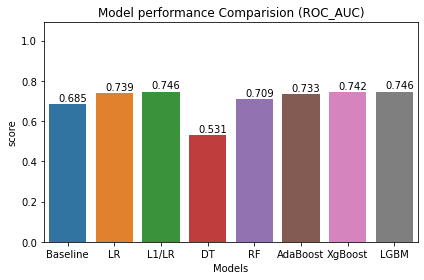

In [42]:
plt.figure(figsize=(6,4))
ax=sns.barplot(x='Models',y='score',data=df_score)
plt.ylim([0,1.09])
plt.title('Model performance Comparision (ROC_AUC)')

for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+0.015))
plt.tight_layout()


#### Business Perspective

In [9]:
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)
y=df['TARGET']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


import lightgbm as lgb

#converting the dataset into proper LGB format 
train_set = lgb.Dataset(data = X_train, label = y_train)


#Specifying the parameter
params={}
params['learning_rate']=0.05
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Binary target feature
params['metric']='binary_logloss' #metric for binary classification
params['max_depth']=75
params['subsample_freq']= 10, 
params['subsample']= 0.9,
params['scale_pos_weight']=7, 
params['reg_lambda']=15, 
params['reg_alpha']=10, 
params['num_leaves']= 25,
params['min_split_gain']= 0.3,
params['colsample_bytree']= 0.5,
params['scale_pos_weight']= 8,


#train the model 
clf_lgbm=lgb.train(params,train_set,194)

#prediction on the test set
y_pred_prob=clf_lgbm.predict(X_test)
y_pred_prob_train=clf_lgbm.predict(X_train)

y_pred= [1 if x >= 0.5 else 0 for x in y_pred_prob]
y_pred_train= [1 if x >= 0.5 else 0 for x in y_pred_prob_train]

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

from sklearn.metrics import roc_auc_score
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

[[46449  9972]
 [ 2435  2588]]
              precision    recall  f1-score   support

           0       0.95      0.82      0.88     56421
           1       0.21      0.52      0.29      5023

    accuracy                           0.80     61444
   macro avg       0.58      0.67      0.59     61444
weighted avg       0.89      0.80      0.83     61444



Train Data Metrics:
[[186951  39041]
 [  8502  11278]]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89    225992
           1       0.22      0.57      0.32     19780

    accuracy                           0.81    245772
   macro avg       0.59      0.70      0.60    245772
weighted avg       0.90      0.81      0.84    245772

roc_auc (training): 0.789
roc_auc (test): 0.754


In [18]:
#Train
df_prob_train=pd.DataFrame(y_train.values,columns=['Actual'])
df_prob_train['Predscore']=y_pred_prob_train
df_prob_train['pred']=y_pred_train
df_prob_train

,Actual,Predscore,pred
0,1,0.471561,0
1,1,0.569626,1
2,0,0.409989,0
3,0,0.354189,0
4,0,0.327828,0
...,...,...,...
245767,0,0.439739,0
245768,1,0.612372,1
245769,0,0.191792,0
245770,0,0.349708,0


In [19]:
#Test
df_prob_test=pd.DataFrame(y_test.values,columns=['Actual'])
df_prob_test['Predscore']=y_pred_prob
df_prob_test['pred']=y_pred
df_prob_test

,Actual,Predscore,pred
0,0,0.249260,0
1,0,0.167015,0
2,0,0.269289,0
3,0,0.415531,0
4,0,0.105893,0
...,...,...,...
61439,0,0.435716,0
61440,0,0.534063,1
61441,0,0.509089,1
61442,0,0.103350,0


In [11]:
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

0    225992
1     19780
Name: TARGET, dtype: int64
0    56421
1     5023
Name: TARGET, dtype: int64


**All the applicants were divided into 10 tiers by qcut in training data, so that wach tier contains approx. equal no. of good applicants.**

In [15]:
#Train
finalResults = pd.DataFrame({
    'Actual' : y_train,
    'PredScore' : y_pred_prob_train#[:,1]
})

finalResults['QuantTier'], Dev_bins = pd.qcut(finalResults['PredScore'], 10, retbins=True, labels=range(1,11))
finalResults.reset_index(inplace=True)

badRateMatrix_train = pd.pivot_table(finalResults, index=['QuantTier'], columns=['Actual'], values = ['index'], aggfunc='count')
print(badRateMatrix_train)

           index      
Actual         0     1
QuantTier             
1          24404   174
2          24228   349
3          24088   489
4          23826   751
5          23611   966
6          23194  1383
7          22652  1925
8          21952  2625
9          20798  3779
10         17239  7339


In [16]:
#Test
finalResults = pd.DataFrame({
    'Actual' : y_test,
    'PredScore' : y_pred_prob
})

finalResults['QuantTier'] = pd.cut(finalResults['PredScore'], bins=Dev_bins, labels=range(1,11))
finalResults.reset_index(inplace=True)

badRateMatrix_test= pd.pivot_table(finalResults, index=['QuantTier'], columns=['Actual'], values = ['index'], aggfunc='count')
print(badRateMatrix_test)

          index      
Actual        0     1
QuantTier            
1          6019    84
2          5934   110
3          6009   173
4          5901   235
5          5940   307
6          5756   388
7          5613   505
8          5570   667
9          5245   938
10         4431  1616


In [36]:
good=badRateMatrix_test['index'][0].values
bad=badRateMatrix_test['index'][1].values
tier=badRateMatrix_test.index
badRate=pd.DataFrame(list(zip(tier,good,bad)), columns=(['tier','good','bad']))
badRate['% good']=badRate['good']/sum(badRate['good'].values)*100
badRate['% bad']=badRate['bad']/sum(badRate['bad'].values)*100
badRate

,tier,good,bad,% good,% bad
0,1,6019,84,10.668581,1.672307
1,2,5934,110,10.517920,2.189926
2,3,6009,173,10.650856,3.444157
3,4,5901,235,10.459428,4.678479
4,5,5940,307,10.528555,6.111885
5,6,5756,388,10.202418,7.724467
6,7,5613,505,9.948952,10.053753
7,8,5570,667,9.872736,13.278917
8,9,5245,938,9.296678,18.674099
9,10,4431,1616,7.853876,32.172009


In [80]:
df=badRate[['tier','% good','% bad']]
df

,tier,% good,% bad
0,1,10.668581,1.672307
1,2,10.517920,2.189926
2,3,10.650856,3.444157
3,4,10.459428,4.678479
4,5,10.528555,6.111885
5,6,10.202418,7.724467
6,7,9.948952,10.053753
7,8,9.872736,13.278917
8,9,9.296678,18.674099
9,10,7.853876,32.172009


In [81]:
df = pd.melt(df, id_vars="tier", var_name="good/bad", value_name="% count")
df

,tier,good/bad,% count
0,1,% good,10.668581
1,2,% good,10.517920
2,3,% good,10.650856
3,4,% good,10.459428
4,5,% good,10.528555
5,6,% good,10.202418
6,7,% good,9.948952
7,8,% good,9.872736
8,9,% good,9.296678
9,10,% good,7.853876


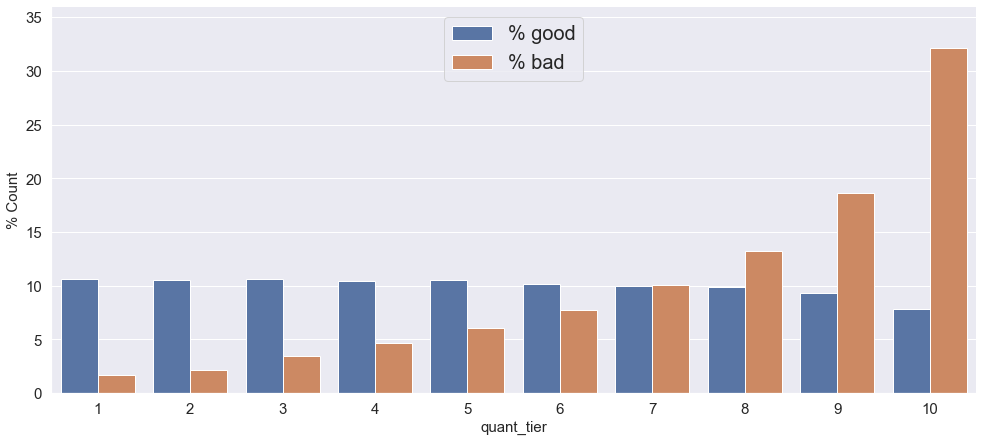

In [110]:
sns.catplot(x='tier', y='% count', hue='good/bad', ax=ax,data=df, kind='bar', height=6, aspect=2.25, legend=None)

plt.legend(loc=9, prop={'size': 20})
plt.xlabel('quant_tier',fontsize=15)
plt.ylabel('% Count',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0,36])

plt.show()
